# Mental Health Survey Clustering Analysis

This notebook supports a mental health mitigation program by analyzing a representative survey of technology-oriented employees. The primary objectives include:

- **Data Exploration**: Understand the data distribution, completeness, and key statistics.
- **Preprocessing**: Handle missing values, normalize and encode data, and address non-standard entries.
- **Dimensionality Reduction**: Apply PCA to reduce complexity while preserving important variance.
- **Clustering**: Use unsupervised methods such as K-Means to segment employees into meaningful clusters.
- **Visualization**: Illustrate clusters and their characteristics for actionable HR insights.

The findings will help human resources design targeted mental health support strategies based on the characteristics of each cluster.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import time
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import MDS


> #### Load the Original Survey Dataset
> In this step, we import the original CSV file containing the mental health survey responses (from https://www.kaggle.com/datasets/osmi/mental-health-in-tech-2016). This dataset serves as the foundation for all subsequent preprocessing, analysis, and clustering tasks.

In [3]:
df = pd.read_csv('mental-heath-in-tech-2016_20161114.csv', encoding='utf-8')

> #### Preview the Dataset  
> To gain an initial understanding of the dataset structure, we display the first few rows. This allows us to observe the types of features available, check for obvious data quality issues, and identify potential preprocessing needs.

In [4]:
# Display the first few rows of the dataset
display(df.head())

,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",...,"If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?","If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",What is your age?,What is your gender?,What country do you live in?,What US state or territory do you live in?,What country do you work in?,What US state or territory do you work in?,Which of the following best describes your work position?,Do you work remotely?
0,0,26-100,1.0,NaN,Not eligible for coverage / N/A,NaN,No,No,I don't know,Very easy,...,Not applicable to me,Not applicable to me,39,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Sometimes
1,0,6-25,1.0,NaN,No,Yes,Yes,Yes,Yes,Somewhat easy,...,Rarely,Sometimes,29,male,United States of America,Illinois,United States of America,Illinois,Back-end Developer|Front-end Developer,Never
2,0,6-25,1.0,NaN,No,NaN,No,No,I don't know,Neither easy nor difficult,...,Not applicable to me,Not applicable to me,38,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Always
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Sometimes,Sometimes,43,male,United Kingdom,NaN,United Kingdom,NaN,Supervisor/Team Lead,Sometimes
4,0,6-25,0.0,1.0,Yes,Yes,No,No,No,Neither easy nor difficult,...,Sometimes,Sometimes,43,Female,United States of America,Illinois,United States of America,Illinois,Executive Leadership|Supervisor/Team Lead|Dev ...,Sometimes


> #### Summary Statistics of the Dataset  
> We generate descriptive statistics for all columns using `df.describe(include='all')`.  
> This includes:
> - **Numerical features**: count, mean, standard deviation, min, max, and quartiles.
> - **Categorical features**: count, number of unique values, most frequent value, and its frequency.  
>  
> This summary helps identify distributions, spot potential outliers, and detect anomalies or inconsistencies across the dataset.

In [5]:
# Create some descriptive statistics for the dataset
df.describe(include='all')

,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",...,"If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?","If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",What is your age?,What is your gender?,What country do you live in?,What US state or territory do you live in?,What country do you work in?,What US state or territory do you work in?,Which of the following best describes your work position?,Do you work remotely?
count,1433.000000,1146,1146.000000,263.000000,1146,1013,1146,1146,1146,1146,...,1433,1433,1433.000000,1430,1433,840,1433,851,1433,1433
unique,NaN,6,NaN,NaN,4,3,3,3,3,6,...,5,5,NaN,70,53,47,53,48,264,3
top,NaN,26-100,NaN,NaN,Yes,No,No,No,I don't know,Somewhat easy,...,Not applicable to me,Often,NaN,Male,United States of America,California,United States of America,California,Back-end Developer,Sometimes
freq,NaN,292,NaN,NaN,531,354,813,531,742,281,...,557,538,NaN,610,840,130,851,141,263,757
mean,0.200279,NaN,0.770506,0.942966,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,34.286113,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.400349,NaN,0.420691,0.232350,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,11.290931,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,28.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,33.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,0.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,39.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dataset Overview

- **Observations:** 1,433  
- **Features:** 63 total (7 numerical, 56 categorical)

#### Data Types
- **Numerical (7):**
  - `int64`: age, self_employed, treatment
  - `float64`: tech_company, tech_role
- **Categorical (56):**
  - Includes e.g. workplace attitudes, mental health history, benefits, demographics

#### Missing Data Patterns
- Complete (no missing values): demographic fields like `age`, `gender`
- Partial: employer-related (~1,146 non-null)
- Sparse: treatment-specific questions (~263–287 non-null)

#### Preprocessing Implications
- Handle missing values
- Encode categorical features
- Apply dimensionality reduction to manage complexity


> #### Visual Exploration of the Dataset  
> Firstly, we generate a visualization of the gender column to find outliers or non-standard entries.

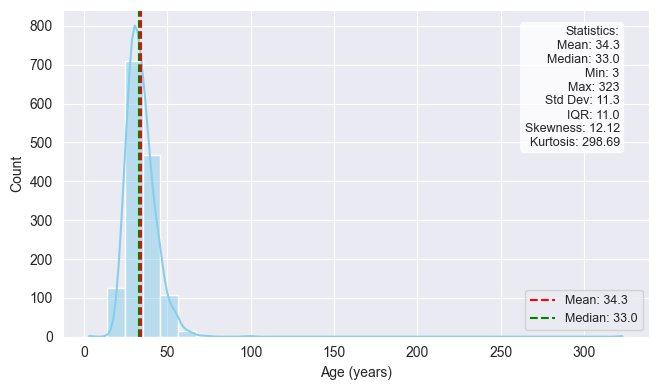

In [6]:
# Rename age column for easier handling
df = df.rename(columns={'What is your age?': 'age'})

# Calculate age statistics
age_mean = df['age'].mean()
age_median = df['age'].median()
age_std = df['age'].std()
age_skew = df['age'].skew()
age_kurtosis = df['age'].kurtosis()
age_iqr = df['age'].quantile(0.75) - df['age'].quantile(0.25)
age_min = df['age'].min()
age_max = df['age'].max()

# Create figure with exact A4 width (minus margins)
plt.figure(figsize=(6.69, 4))  # Width matches A4 margins, height adjusted for proportion

# Set font to match document
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# Create the main distribution plot
sns.histplot(data=df, x='age', bins=30, kde=True, color='skyblue')

# Add a vertical line for mean and median
plt.axvline(age_mean, color='red', linestyle='--', label=f'Mean: {age_mean:.1f}')
plt.axvline(age_median, color='green', linestyle='--', label=f'Median: {age_median:.1f}')

# Customize the plot
plt.xlabel('Age (years)', fontsize=10)
plt.ylabel('Count', fontsize=10)

# Add statistical annotations in a text box
stats_text = (f'Statistics:\n'
            f'Mean: {age_mean:.1f}\n'
            f'Median: {age_median:.1f}\n'
            f'Min: {age_min}\n'
            f'Max: {age_max}\n'
            f'Std Dev: {age_std:.1f}\n'
            f'IQR: {age_iqr:.1f}\n'
            f'Skewness: {age_skew:.2f}\n'
            f'Kurtosis: {age_kurtosis:.2f}')

# Place text box in upper right corner
plt.text(0.95, 0.95, stats_text,
        transform=plt.gca().transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
        fontsize=9)  # Slightly smaller font for stats

# Add legend with smaller font
plt.legend(fontsize=9)

# Adjust layout to prevent text cutoff
plt.tight_layout()

# Save with exact dimensions and high DPI for clarity
plt.savefig('age_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Age Distribution Analysis

- **Mean Age:** 34.3 years  
- **Median Age:** 33.0 years → suggests a slightly right-skewed distribution  
- **Range:** 3 to 323 years  
  - Minimum age of 3 and maximum of 323 are clearly invalid (data entry errors)  
- **Standard Deviation:** 11.3 years (moderate spread excluding outliers)  
- **IQR:** 11.0 years → middle 50% of respondents are within an 11-year span  
- **Skewness:** +12.12 → strong right skew due to extreme outliers  
- **Kurtosis:** 298.69 → presence of heavy tails and extreme values  

#### Data Quality Implications
1. **Clean invalid age values** (e.g., ages < 16 or > 100)  
2. **Implement input validation** in future surveys  
3. **Use robust statistics** (median, IQR) instead of mean/std  
4. **Focus analysis on realistic age range** to improve reliability  

Despite outliers, most respondents are in their **early to mid-30s** — a key demographic for targeted mental health interventions.

> #### Now we generate a visualization for the gender column

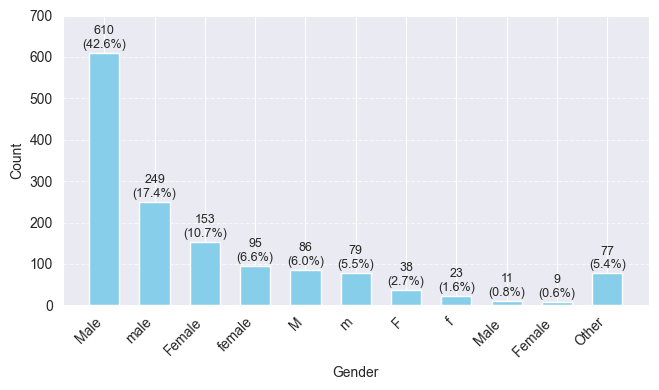

In [7]:
# Create figure with exact A4 width (minus margins)
plt.figure(figsize=(6.69, 4))

# Set font to match overleaf document sizes
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# Calculate statistics and group smaller categories
gender_counts = df['What is your gender?'].value_counts()
top_10 = gender_counts.head(10)
other_sum = gender_counts[10:].sum()

# Create new series with Other at the end
final_counts = pd.concat([top_10, pd.Series({'Other': other_sum})])

total_responses = len(df)

# Create bar plot
bars = plt.bar(range(len(final_counts)), 
               final_counts.values, 
               color='skyblue', 
               width=0.6)

# Add value labels on bars
for i, v in enumerate(final_counts.values):
    percentage = (v/total_responses) * 100
    plt.text(i, v + 5,
             f'{v:,}\n({percentage:.1f}%)', 
             ha='center', 
             va='bottom',
             fontsize=9) 

# Customize the plot
plt.xlabel('Gender', fontsize=10)
plt.ylabel('Count', fontsize=10)

# Set x-axis labels
plt.xticks(range(len(final_counts)), final_counts.index, rotation=45, ha='right')

# Set y-axis limits
plt.ylim(0, 700)

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent text cutoff
plt.tight_layout()

# Save with exact dimensions and high DPI for clarity
plt.savefig('gender_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Gender Distribution Overview

#### Primary Patterns
- **Male-identifying responses:** ~72% of all entries  
  - Dominant forms: `"Male"` (42.6%), `"male"` (17.4%), `"M"/"m"` (11.5%)
- **Female-identifying responses:** ~23%  
  - Dominant forms: `"Female"` (10.7%), `"female"` (6.6%), `"F"/"f"` (4.3%)
- **Non-binary and other identities:** ~5%  
  - Includes detailed gender identity descriptions and diverse expressions

#### Data Quality Observations
- **70 unique gender labels** indicate inconsistent and unstandardized input
- **Top 8 entries** account for **93.1%** of responses
- Remaining **62 entries** are rare (≤ 0.8% each), including:
  - Case variants (`"Male"` vs `"male"`)
  - Informal, non-standardized, or protest responses

#### Statistical & Analytical Implications
1. **Standardization** of gender inputs is essential for analytical consistency  
2. **Case sensitivity** significantly inflates category count  
3. **Non-binary representation (~5%)** should be preserved and respected 

The gender distribution reflects the male-dominant trend typical in the tech industry.



> #### Next we are going to look at the geolocation of the participants

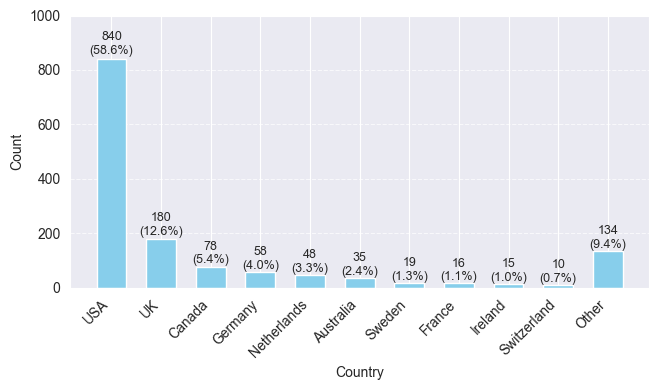

In [8]:
# Create figure with exact A4 width (minus margins)
plt.figure(figsize=(6.69, 4))

# Set font to match overleaf document size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# Calculate statistics and clean country names
country_counts = df['What country do you live in?'].replace({
    'United States of America': 'USA',
    'United Kingdom': 'UK'
}).value_counts()

# Get top 10 and sum others
top_10 = country_counts.head(10)
other_sum = country_counts[10:].sum()

# Create new series with Other at the end
final_counts = pd.concat([top_10, pd.Series({'Other': other_sum})])

total_responses = len(df)

# Create bar plot
bars = plt.bar(range(len(final_counts)), 
               final_counts.values, 
               color='skyblue', 
               width=0.6)

# Add value labels on bars
for i, v in enumerate(final_counts.values):
    percentage = (v/total_responses) * 100
    plt.text(i, v + (v * 0.01),
             f'{v:,}\n({percentage:.1f}%)', 
             ha='center', 
             va='bottom',
             fontsize=9)

# Customize the plot
plt.xlabel('Country', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.ylim(0, 1000)

# Set x-axis labels
plt.xticks(range(len(final_counts)), final_counts.index, rotation=45, ha='right')

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Save with high resolution
plt.savefig('country_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Country Distribution

#### Primary Distribution Patterns
- **United States:** 840 responses (58.6%) — largest single-country representation  
- **United Kingdom:** 180 responses (12.6%) — leading European country  
- **Canada:** 78 responses (5.4%) — strengthens North American presence  
- **Continental Europe:** Fragmented, with Germany (4.0%) and Netherlands (3.3%) as primary contributors  
- **Asia-Pacific:** Minimal representation, led by Australia (2.4%) with sparse responses from other countries  

#### Regional Concentration Analysis
- **English-speaking countries:** ~76.6% of total sample (US, UK, Canada, Australia, etc.)  
- **Western Europe:** ~15%, but split across several countries  
- **Emerging tech regions** (Asia, South America, Eastern Europe): each < 1%  
- Minimal input from notable tech hubs such as **Israel**, **Singapore**, and **India**  
- **Developing economies:** Largely underrepresented

#### Statistical Implications
1. **US-dominant sample** supports strong North American tech sector insights  
2. **UK and Canada** provide comparative benchmarks, but with lower statistical power  
3. **Low global representation** limits generalizability beyond Anglophone markets  
4. **Reliable country-level analysis** feasible for only top 3–5 nations  
5. **Caution required** when interpreting findings from countries with <20 responses

The dataset is heavily skewed toward **Anglo-American regions**, especially the United States, indicating that findings will primarily reflect the context of English-speaking tech workforces.

> #### Next we are going to look at the Remote Work Status

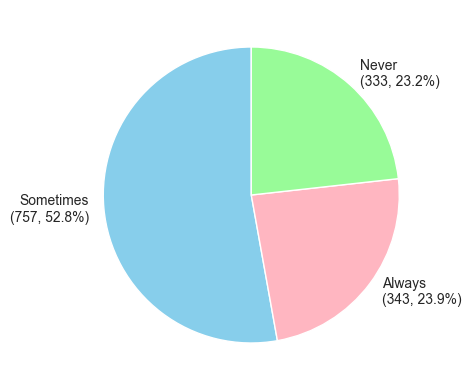

In [9]:
# Create figure with exact A4 width (minus margins)
plt.figure(figsize=(6.69, 4))

# Set font to match document requirements
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# Calculate remote work distribution
remote_counts = df['Do you work remotely?'].value_counts()
total_responses = len(df)

# Create pie chart using skyblue and complementary colors
plt.pie(remote_counts.values, 
        labels=[f'{label}\n({count:,}, {(count/total_responses)*100:.1f}%)' 
                for label, count in zip(remote_counts.index, remote_counts.values)],
        colors=['skyblue', '#FFB6C1', '#98FB98'],  # skyblue, lightpink, palegreen
        autopct='',
        startangle=90)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save with high resolution
plt.savefig('remote_work_distribution.png', 
            dpi=300, 
            bbox_inches='tight')

plt.show()

### Remote Work Distribution

#### Primary Distribution Patterns:
- **Hybrid Work:** Majority representation with **757 respondents (52.8%)** indicating they "sometimes" work remotely.
- **Full Remote vs. No Remote Work:** Almost equally represented, with **343 respondents (23.9%)** "always" remote and **333 respondents (23.2%)** "never" remote.
- **Overall Remote Arrangement:** A substantial **76.7%** (combining "sometimes" and "always") have remote work flexibility.

#### Pattern Analysis:
- **Dominance of Hybrid Work:** Reflects the tech industry's preference for flexible, hybrid work practices.
- **Polarization of Work Models:** The nearly equal distribution between fully remote and strictly onsite work indicates a clear division within industry preferences.
- **High Response Rate:** Suggests a high reliability and quality of the data for analytical purposes.

#### Statistical Implications:
1. **Robust Analysis Opportunity:** The large hybrid group (52.8%) offers a strong foundation for analyzing the impact of flexible working conditions on mental health.
2. **Balanced Comparative Groups:** The roughly equal representation of fully remote (23.9%) and no remote (23.2%) facilitates rigorous comparative analyses.
3. **Reliable Statistical Inferences:** Adequate sample sizes in all categories ensure meaningful statistical validity and interpretability of results.

> #### Next we are going to look at the Self-employment Status

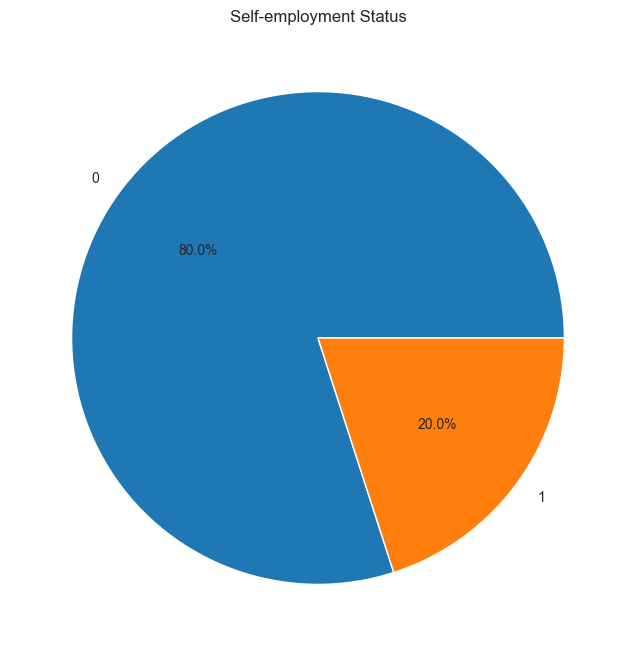

In [10]:
selfemp_counts = df['Are you self-employed?'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(selfemp_counts.values, labels=selfemp_counts.index, autopct='%1.1f%%')
plt.title('Self-employment Status')
plt.show()

### Self-Employment Status

#### Primary Distribution Patterns:
- **Company Employment:** Clearly dominates, with **1,146 respondents (80%)** working as traditional company employees.
- **Self-Employment:** Represents a notable minority, with **287 respondents (20%)**.
- **High Response Completeness:** Nearly complete responses in this category indicate reliable data quality.

#### Pattern Analysis:
- **Dominance of Traditional Employment:** Reflects the prevalence of structured corporate environments in the tech industry.
- **Meaningful Self-Employment Segment:** The significant minority of self-employed respondents highlights the substantial presence of independent professionals within the industry.
- **Representative Distribution:** Aligns well with common employment patterns observed in the broader technology sector.

#### Statistical Implications:
1. **Robust Corporate Analysis:** The large sample of company employees (80%) provides an excellent foundation for exploring mental health practices within structured corporate settings.
2. **Comparative Insights:** Adequate self-employed group size (20%) allows meaningful comparative studies of mental health between different employment structures.
3. **Simplified Statistical Approach:** The clear binary distribution facilitates straightforward statistical methods and interpretations.
4. **Reliable Data Quality:** The high response completeness enhances the reliability and generalizability of analyses conducted on employment status.

> #### Next we are going to look at the Mental Health Benefits Awareness

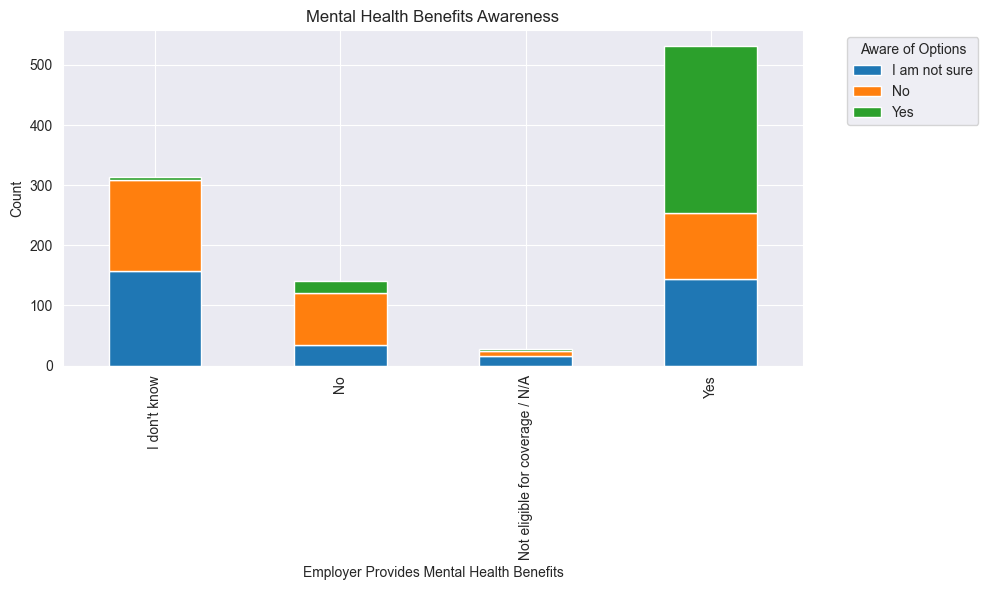

In [11]:
benefits_aware = pd.crosstab(df['Does your employer provide mental health benefits as part of healthcare coverage?'], 
                             df['Do you know the options for mental health care available under your employer-provided coverage?'])
benefits_aware.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Mental Health Benefits Awareness')
plt.xlabel('Employer Provides Mental Health Benefits')
plt.ylabel('Count')
plt.legend(title='Aware of Options', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Mental Health Benefits Availability and Awareness

#### Primary Distribution Patterns:
- **Benefit Provision:** A substantial number of employers provide mental health benefits, representing the largest category.
- **Benefit Uncertainty:** Many employees are uncertain if their employers provide mental health benefits.
- **Awareness Variation:** Awareness levels among employees vary widely, even in companies with confirmed benefit policies.
- **Eligibility Status:** A very small fraction of employees report ineligibility for mental health benefits coverage.

#### Pattern Analysis:
- **Recognition of Mental Health:** The high provision of mental health benefits suggests an increasing acknowledgment of its importance by employers.
- **Communication Challenges:** The significant proportion of employees uncertain about benefit policies highlights systemic issues in internal communication.
- **Utilization Gaps:** Mixed awareness within companies offering clear mental health benefits indicates gaps between policy existence and actual employee awareness.
- **Systematic Opportunities:** The observed disparities emphasize opportunities to standardize and streamline benefit communication practices across the tech industry.

#### Statistical Implications:
1. **Robust Analytical Foundation:** The high number of benefit-providing employers allows comprehensive analysis of benefit implementation and effectiveness.
2. **Communication Improvement:** A considerable portion of "unsure" responses emphasizes the need for improved communication strategies within companies.
3. **Focused Communication Analysis:** The clear disparity between available benefits and employee awareness underlines communication as a critical focal point for analysis.
4. **Standardization Opportunity:** Strong variability in employee knowledge regarding mental health benefits suggests the potential for standardized industry-wide communication protocols.

> #### Next we are going to look if Employees are comfortable discussing their mental health with their coworkers and supervisors

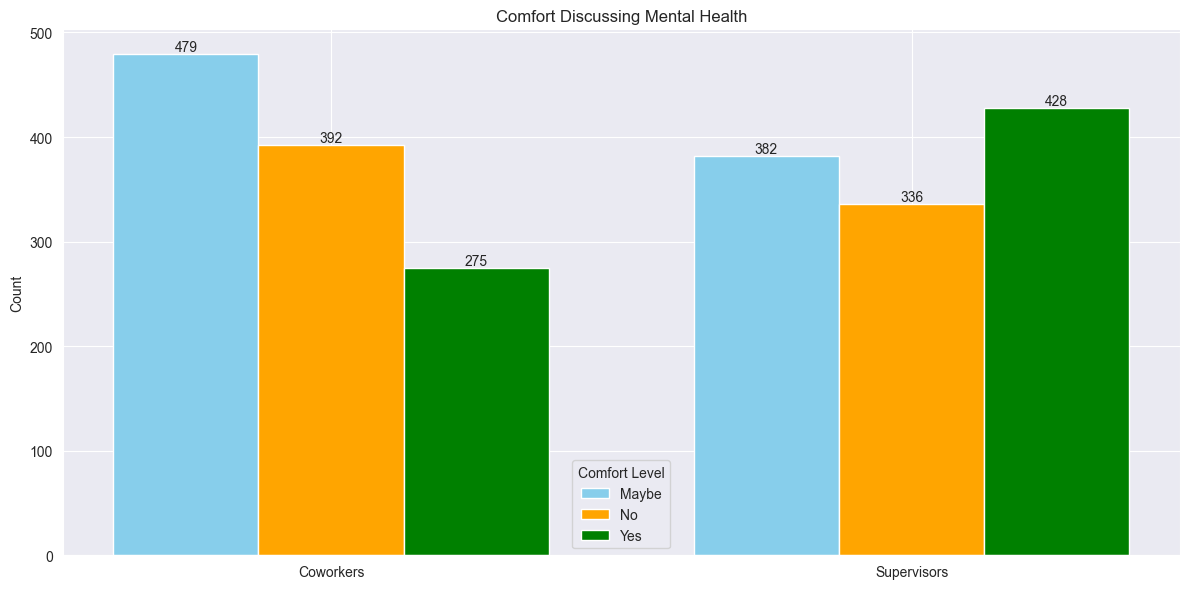

In [12]:
comfort_data = df[['Would you feel comfortable discussing a mental health disorder with your coworkers?',
                   'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?']]
comfort_data = comfort_data.melt(var_name='Discuss With', value_name='Comfort Level')
comfort_data['Discuss With'] = comfort_data['Discuss With'].map({
    'Would you feel comfortable discussing a mental health disorder with your coworkers?': 'Coworkers',
    'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?': 'Supervisors'
})

# Count the data
count_data = comfort_data.groupby(['Discuss With', 'Comfort Level']).size().unstack(fill_value=0)

# Set up the plot
plt.figure(figsize=(12, 6))
ax = plt.subplot()

# Define bar width and positions
bar_width = 0.25
r1 = np.arange(len(count_data.index))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot the bars
bars1 = ax.bar(r1, count_data['Maybe'], bar_width, label='Maybe', color='skyblue')
bars2 = ax.bar(r2, count_data['No'], bar_width, label='No', color='orange')
bars3 = ax.bar(r3, count_data['Yes'], bar_width, label='Yes', color='green')

# Add labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height}',
                ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Customize the plot
plt.title('Comfort Discussing Mental Health')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks([r + bar_width for r in range(len(count_data.index))], count_data.index)
plt.legend(title='Comfort Level')

plt.tight_layout()
plt.show()

### Comfort Discussing Mental Health at the Workplace

#### Primary Distribution Patterns:
- **Supervisor Discussions:** Respondents show higher comfort (428 respondents) when discussing mental health with supervisors.
- **Peer Discussions:** Lower comfort level observed when discussing with coworkers (275 respondents).
- **Dominance of "Maybe" Responses:** High uncertainty levels recorded for discussions with both coworkers (479 respondents) and supervisors (382 respondents).
- **Discomfort Levels:** Notably higher discomfort reported in discussions with coworkers (392) compared to supervisors (336).
- **Combined Hesitancy:** Aggregate of "Maybe" and "No" responses surpasses affirmative comfort levels in both categories.

#### Pattern Analysis:
- **Hierarchical Preference:** Clear preference for discussing mental health with supervisors rather than coworkers.
- **Peer Communication Hesitancy:** Significant discomfort indicates challenges in peer-to-peer mental health conversations.
- **Contextual Influences:** Variable comfort levels suggest that situational and relational contexts significantly affect employee openness.
- **Uncertainty Indicators:** Systematic high levels of uncertainty highlight possible gaps in clear organizational communication or policy guidelines.

#### Statistical Implications:
1. **Targeted Intervention:** Distinct contrast between comfort levels with supervisors and coworkers points towards specific, hierarchy-focused communication strategies.
2. **Need for Structural Changes:** High prevalence of "Maybe" responses underscores a demand for clearer communication guidelines and mental health resources.
3. **Strategic Communication Opportunities:** Clear hierarchical preferences suggest potential for targeted training and awareness campaigns focused on supervisors.
4. **Best Practices Identification:** Balanced response distribution regarding supervisors indicates existing good practices that could be modeled or expanded upon.

> #### Next we are going to look about how many missing values the data has


In [13]:
# Calculate the number and percentage of missing values
missing_values = df.isnull().sum()
missing_percentages = 100 * df.isnull().sum() / len(df)

# Combine into a table
missing_table = pd.concat([missing_values, missing_percentages], axis=1, keys=['Missing Values', 'Percentage Missing'])

# Sort by the number of missing values in descending order
missing_table = missing_table.sort_values('Missing Values', ascending=False)

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Display the table
print(missing_table)

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')

                                                    Missing Values  \
If you have revealed a mental health issue to a...            1289   
If yes, what percentage of your work time (time...            1229   
Is your primary role within your company relate...            1170   
Do you have medical coverage (private insurance...            1146   
If you have been diagnosed or treated for a men...            1146   
If you have been diagnosed or treated for a men...            1146   
If you have revealed a mental health issue to a...            1146   
Do you know local or online resources to seek h...            1146   
Do you believe your productivity is ever affect...            1146   
If maybe, what condition(s) do you believe you ...            1111   
If yes, what condition(s) have you been diagnos...             865   
Have your observations of how another individua...             776   
If so, what condition(s) were you diagnosed with?              722   
What US state or ter

> #### There are a few columns that we will need to drop because too many values are missing, if e.g. over 50% of values are missing. When the data is cleaned the issue of missing values needs to be addressed.

> #### As a next step in the data exploration step, we look is there is any correlation between the family history of mental illness and the current mental health disorder status. We will do this by creating a cross-tabulation of the two variables and then visualizing it with a stacked bar chart.

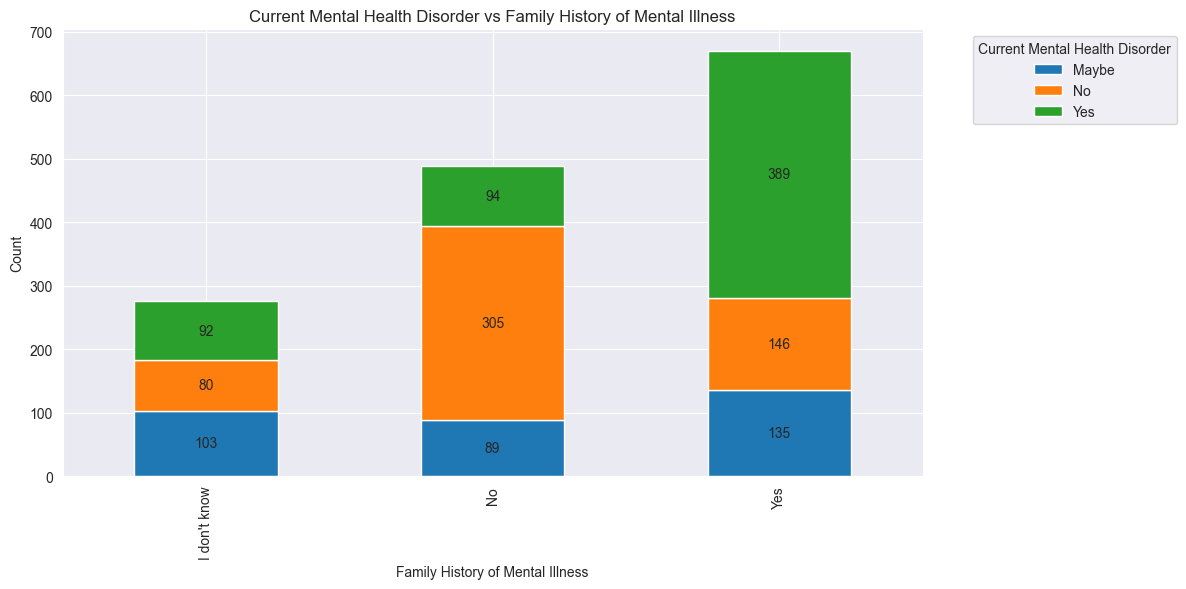

In [14]:
# Create a cross-tabulation of the two variables
cross_tab = pd.crosstab(df['Do you have a family history of mental illness?'], 
                        df['Do you currently have a mental health disorder?'])

# Create a stacked bar chart
ax = cross_tab.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Current Mental Health Disorder vs Family History of Mental Illness')
plt.xlabel('Family History of Mental Illness')
plt.ylabel('Count')
plt.legend(title='Current Mental Health Disorder', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, label_type='center')

plt.show()

### Current Mental Health Disorder vs. Family History of Mental Illness

#### Primary Distribution Patterns:
- **Strong Family Influence:** A clear correlation observed with **58% (389 respondents)** reporting current mental health disorders and a known family history.
- **Absence of Family History:** Majority (**62.5% or 305 respondents**) without a family history of mental illness report no current disorders.
- **High Uncertainty:** Significant uncertainty exists regarding family mental health history (**275 respondents**), exhibiting balanced distributions of mental health disorders.
- **Disorders Without Family History:** Notable proportion (**19% or 94 respondents**) report current disorders despite no known family history.

#### Pattern Analysis:
- **Influence but Not Determinism:** Family history presents a strong correlation but does not deterministically predict current disorders.
- **Complex Influences:** The distribution underscores the multifactorial nature of mental health, involving genetic and environmental interactions.
- **Knowledge Gaps:** Significant uncertainty regarding family mental health history highlights potential gaps in health awareness and documentation.
- **Genetic-Environmental Interplay:** The data clearly illustrates the complexity and interplay of hereditary and external factors influencing mental health.

#### Statistical Implications:
1. **Focused Support Strategies:** Strong correlations facilitate targeted mental health support and preventive strategies for individuals with known family histories.
2. **Comprehensive Approaches Required:** The significant presence of mental health disorders in respondents without a family history supports the necessity for broad-based intervention frameworks.
3. **Enhanced Awareness Initiatives:** Even distribution among uncertain respondents indicates a need for initiatives aimed at improving family health history documentation and awareness.
4. **Risk-Based Intervention Development:** Clearly discernible distribution patterns enable informed, risk-factor-based interventions tailored to varying levels of familial mental health risks. 

> #### Next step is to look at the current mental health disorder status of the participants. We will do this by creating a pie chart of the current mental health disorder status.


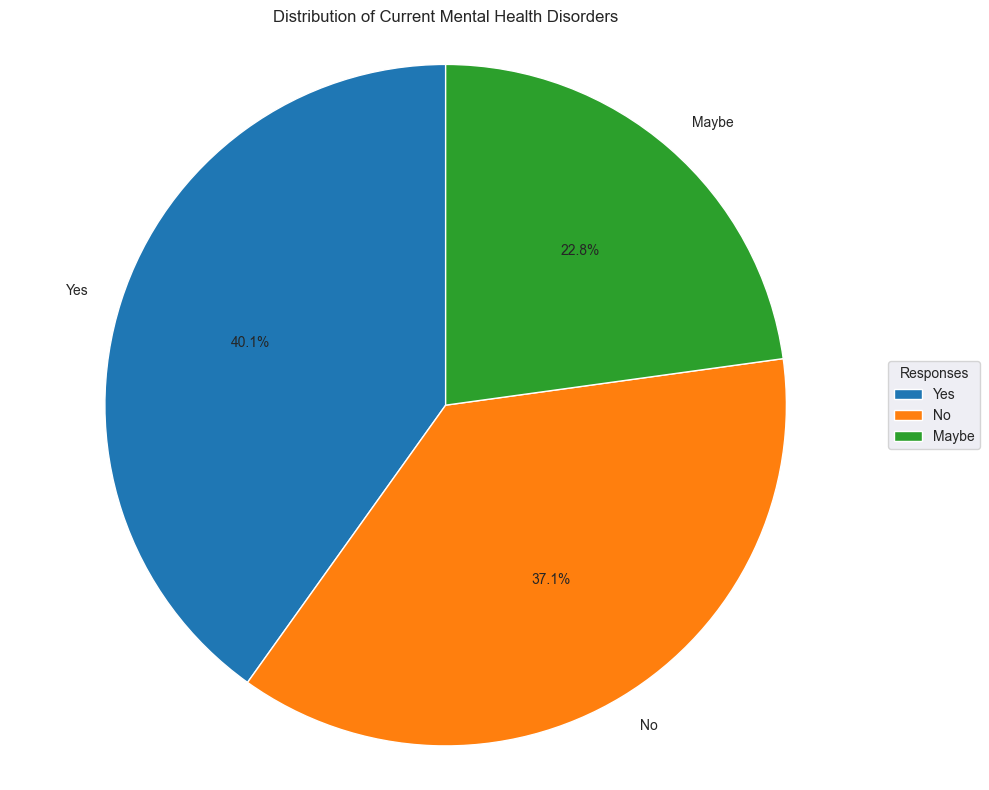

Do you currently have a mental health disorder?
Yes      575
No       531
Maybe    327
Name: count, dtype: int64


In [15]:
# Count the values in the column
value_counts = df['Do you currently have a mental health disorder?'].value_counts()

# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Current Mental Health Disorders')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Add a legend
plt.legend(title="Responses", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

# Print the exact counts
print(value_counts)

### Current Mental Health Disorder Distribution

#### Primary Distribution Patterns:
- **High Prevalence:** A significant proportion of respondents (**40.1%, 575 respondents**) report having a current mental health disorder.
- **No Disorders:** Substantial representation of respondents (**37.1%, 531 respondents**) who clearly indicate no current mental health disorders.
- **Notable Uncertainty:** A meaningful segment (**22.8%, 327 respondents**) remains uncertain about their mental health status.
- **Combined Majority:** Respondents either affected by or uncertain about mental health disorders collectively form the majority (**62.9%**).

#### Pattern Analysis:
- **Balanced Distribution:** Nearly equal representation of respondents reporting and not reporting mental health disorders suggests a balanced distribution within the population.
- **Underreporting Potential:** High uncertainty may indicate underreporting due to diagnostic barriers or lack of mental health awareness.
- **Industry-Wide Issue:** Elevated prevalence highlights significant mental health challenges within the tech sector.
- **Reduced but Persistent Stigma:** The willingness of many to openly report mental health status suggests diminishing stigma, though stigma and uncertainty still persist.

#### Statistical Implications:
1. **Robust Analytical Basis:** The substantial proportion of respondents reporting mental health disorders provides a strong foundation for detailed analysis and targeted support measures.
2. **Diagnostic and Awareness Gaps:** The considerable uncertainty highlights potential gaps in diagnostic access and mental health awareness within the industry.
3. **Comparative Analysis Feasibility:** The near-balanced distribution allows for meaningful comparative analysis between affected and unaffected groups.
4. **Resource Allocation Justification:** High prevalence rates underscore the need for dedicated mental health resources and interventions across the industry.

# Feature Engineering - Data Preprocessing

#### We need to clean some columns before we continue. This includes renaming all columns for easier handling, such that we dont need to use the complete question string further on. Also we will standardize age column, mental health condition columns and convert all categorical columns to binary numerical columns.

In [16]:
# Rename all columns so they are handled more easily
# Define a dictionary to map old column names to new ones
column_map = {
    'Are you self-employed?': 'self_employed',
    'How many employees does your company or organization have?': 'company_size',
    'Is your employer primarily a tech company/organization?': 'tech_company',
    'Is your primary role within your company related to tech/IT?': 'tech_role',
    'Does your employer provide mental health benefits as part of healthcare coverage?': 'emp_mh_benefits',
    'Do you know the options for mental health care available under your employer-provided coverage?': 'know_mh_options',
    'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?': 'emp_discussed_mh',
    'Does your employer offer resources to learn more about mental health concerns and options for seeking help?': 'mh_resources',
    'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?': 'anonymity_protected',
    'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:': 'leave_difficulty',
    'Do you think that discussing a mental health disorder with your employer would have negative consequences?': 'neg_consequences_mental_discuss',
    'Do you think that discussing a physical health issue with your employer would have negative consequences?': 'neg_consequences_physical_discuss',
    'Would you feel comfortable discussing a mental health disorder with your coworkers?': 'comfortable_discuss_coworkers',
    'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?': 'comfortable_discuss_supervisors',
    'Do you feel that your employer takes mental health as seriously as physical health?': 'emp_mh_seriously',
    'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?': 'observed_neg_consequences',
    'Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues?': 'mh_coverage',
    'Do you know local or online resources to seek help for a mental health disorder?': 'know_local_online_resources',
    'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?': 'reveal_clients',
    'If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?': 'neg_impact_reveal_clients',
    'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?': 'reveal_coworkers',
    'If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?': 'neg_impact_reveal_coworkers',
    'Do you believe your productivity is ever affected by a mental health issue?': 'mh_affects_productivity',
    'If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?': 'productivity_affected_percent',
    'Do you have previous employers?': 'previous_emp',
    'Have your previous employers provided mental health benefits?': 'previous_emp_mh_benefits',
    'Were you aware of the options for mental health care provided by your previous employers?': 'aware_prev_mh_options',
    'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?': 'prev_employers_discussed_mh',
    'Did your previous employers provide resources to learn more about mental health issues and how to seek help?': 'prev_mh_resources',
    'Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?': 'prev_anonymity_protected',
    'Do you think that discussing a mental health disorder with previous employers would have negative consequences?': 'prev_neg_consequences_discuss',
    'Do you think that discussing a physical health issue with previous employers would have negative consequences?': 'prev_neg_consequences_physical',
    'Would you have been willing to discuss a mental health issue with your previous co-workers?': 'prev_comfortable_discuss_coworkers',
    'Would you have been willing to discuss a mental health issue with your direct supervisor(s)?': 'prev_comfortable_discuss_supervisors',
    'Did you feel that your previous employers took mental health as seriously as physical health?': 'prev_emp_mh_seriously',
    'Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?': 'prev_observed_neg_consequences',
    'Would you be willing to bring up a physical health issue with a potential employer in an interview?': 'mention_discuss_physical_interview',
    'Why or why not?': 'mention_discuss_physical_interview_reason',
    'Would you bring up a mental health issue with a potential employer in an interview?': 'mention_discuss_mh_interview',
    'Why or why not?.1': 'mention_discuss_mh_interview_reason',
    'Do you feel that being identified as a person with a mental health issue would hurt your career?': 'mh_hurt_career',
    'Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?': 'coworkers_view_negatively',
    'How willing would you be to share with friends and family that you have a mental illness?': 'willing_share_friends_family',
    'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?': 'experienced_unsupportive_response',
    'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?': 'others_experience_affect_you',
    'Do you have a family history of mental illness?': 'family_history',
    'Have you had a mental health disorder in the past?': 'past_mh_disorder',
    'Do you currently have a mental health disorder?': 'current_mh_disorder',
    'If yes, what condition(s) have you been diagnosed with?': 'diagnosed_conditions',
    'If maybe, what condition(s) do you believe you have?': 'believed_conditions',
    'Have you been diagnosed with a mental health condition by a medical professional?': 'professionally_diagnosed',
    'If so, what condition(s) were you diagnosed with?': 'professional_diagnoses',
    'Have you ever sought treatment for a mental health issue from a mental health professional?': 'sought_treatment',
    'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?': 'work_interference_treated',
    'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?': 'work_interference_untreated',
    'What is your age?': 'age',
    'What is your gender?': 'gender',
    'What country do you live in?': 'country',
    'What US state or territory do you live in?': 'state',
    'What country do you work in?': 'work_country',
    'What US state or territory do you work in?': 'work_state',
    'Which of the following best describes your work position?': 'position',
    'Do you work remotely?': 'remote_work'
}

# Rename the columns
df.rename(columns=column_map, inplace=True)

In [17]:
# Clean up the gender column
male_values = [
   'male', 'Male ', 'M', 'm', 'man', 'Cis male',
   'Male.', 'Male (cis)', 'Man', 'Sex is male',
   'cis male', 'Malr', 'Dude', "I'm a man why didn't you make this a drop down question. You should of asked sex? And I would of answered yes please. Seriously how much text can this take? ",
   'mail', 'M|', 'male ', 'Cis Male', 'Male (trans, FtM)',
   'cisdude', 'cis man', 'MALE'
]

female_values = [
   'female', 'I identify as female.', 'female ',
   'Female assigned at birth ', 'F', 'Woman', 'fm', 'f',
   'Cis female', 'Transitioned, M2F', 'Female or Multi-Gender Femme',
   'Female ', 'woman', 'female/woman', 'Cisgender Female', 
   'mtf', 'fem', 'Female (props for making this a freeform field, though)',
   ' Female', 'Cis-woman', 'AFAB', 'Transgender woman',
   'Cis female '
]

other_values = [
   'Bigender', 'non-binary,', 'Genderfluid (born female)',
   'Other/Transfeminine', 'Androgynous', 'male 9:1 female, roughly',
   'nb masculine', 'genderqueer', 'Human', 'Genderfluid',
   'Enby', 'genderqueer woman', 'Queer', 'Agender', 'Fluid',
   'Genderflux demi-girl', 'female-bodied; no feelings about gender',
   'non-binary', 'Male/genderqueer', 'Nonbinary', 'Other', 'none of your business',
   'Unicorn', 'human', 'Genderqueer'
]

# Print total number of responses before preprocessing
print("Total responses before preprocessing:", len(df))

df['gender'] = df['gender'].replace(male_values, 'Male')
df['gender'] = df['gender'].replace(female_values, 'Female')
df['gender'] = df['gender'].replace(other_values, 'Others')

# Replace missing values with the mode Male
df['gender'] = df['gender'].replace(np.nan, 'Male')

# I later decided to drop "Other" gender
df = df[df['gender']!= 'Others']

# Print gender distribution statistics
print("\nGender Distribution after preprocessing:")
gender_counts = df['gender'].value_counts()
gender_percentages = df['gender'].value_counts(normalize=True) * 100

for gender in gender_counts.index:
   print(f"{gender}: {gender_counts[gender]} ({gender_percentages[gender]:.1f}%)")

# Print number of originally non-standardized entries
print(f"\nOriginal variations in gender responses:")
print(f"Male variations: {len(male_values)}")
print(f"Female variations: {len(female_values)}")
print(f"Other variations: {len(other_values)}")

# Print total after preprocessing
print("\nTotal responses after preprocessing:", len(df))

Total responses before preprocessing: 1433

Gender Distribution after preprocessing:
Male: 1061 (75.6%)
Female: 343 (24.4%)

Original variations in gender responses:
Male variations: 22
Female variations: 23
Other variations: 25

Total responses after preprocessing: 1404


In [18]:
# In this part we exclude some data from the dataframe that we don't want to use in our analysis
print(f"Original number of records: {len(df)}")

# Drop all rows where self_employed is 1, because from HR perspective only "normal" employees are relevant and afterward drop the column
df = df[df['self_employed'] == 0]
df=df.drop(columns=['self_employed'])
df = df.reset_index(drop=True)

print(f"Records after removing self-employed: {len(df)}")

# Drop all rows that are not USA and afterward drop column
df = df[df['work_country'] == 'United States of America']
df=df.drop(columns=['work_country'])
df = df.reset_index(drop=True)

print(f"Final records after USA filter: {len(df)}")

Original number of records: 1404
Records after removing self-employed: 1121
Final records after USA filter: 704


> In the next step we will again look at the age distribution of the participants, because we want to exclude outlier data and replace them with median values.

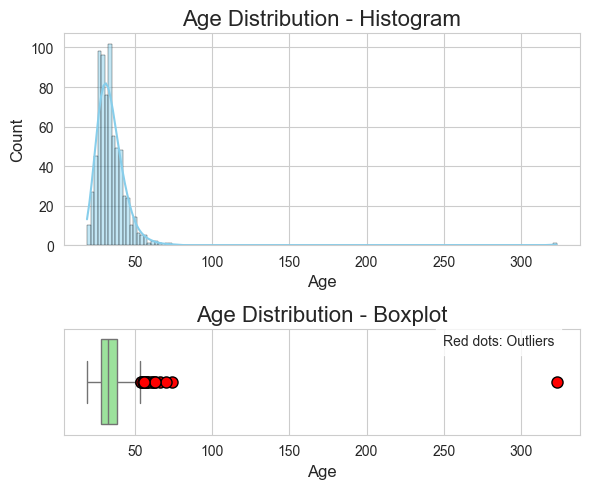

In [19]:
# Set the style for the plot
sns.set_style("whitegrid")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), height_ratios=[2, 1])

# Histogram plot
sns.histplot(data=df, x='age', kde=True, color='skyblue', edgecolor='black', ax=ax1)
ax1.set_title('Age Distribution - Histogram', fontsize=16)
ax1.set_xlabel('Age', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)

# Boxplot with marked outliers
sns.boxplot(data=df, x='age', color='lightgreen', ax=ax2, 
            flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 8, 'markeredgecolor': 'black'})
ax2.set_title('Age Distribution - Boxplot', fontsize=16)
ax2.set_xlabel('Age', fontsize=12)

# Add a text annotation explaining the outliers
ax2.text(0.95, 0.95, 'Red dots: Outliers', transform=ax2.transAxes, 
         verticalalignment='top', horizontalalignment='right',
         bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [20]:
# Find relevant outliers to replace them
# Get the top 5 max values
top_10 = df['age'].nlargest(10)

# Get the bottom 5 min values
bottom_10 = df['age'].nsmallest(10)

print("Top 10 maximum ages:")
print(top_10)

print("\nBottom 10 minimum ages:")
print(bottom_10)

Top 10 maximum ages:
292    323
532     74
602     70
358     66
377     63
603     63
305     62
253     61
362     59
330     58
Name: age, dtype: int64

Bottom 10 minimum ages:
290    19
151    20
386    20
620    20
89     21
304    21
333    21
638    21
639    21
649    21
Name: age, dtype: int64


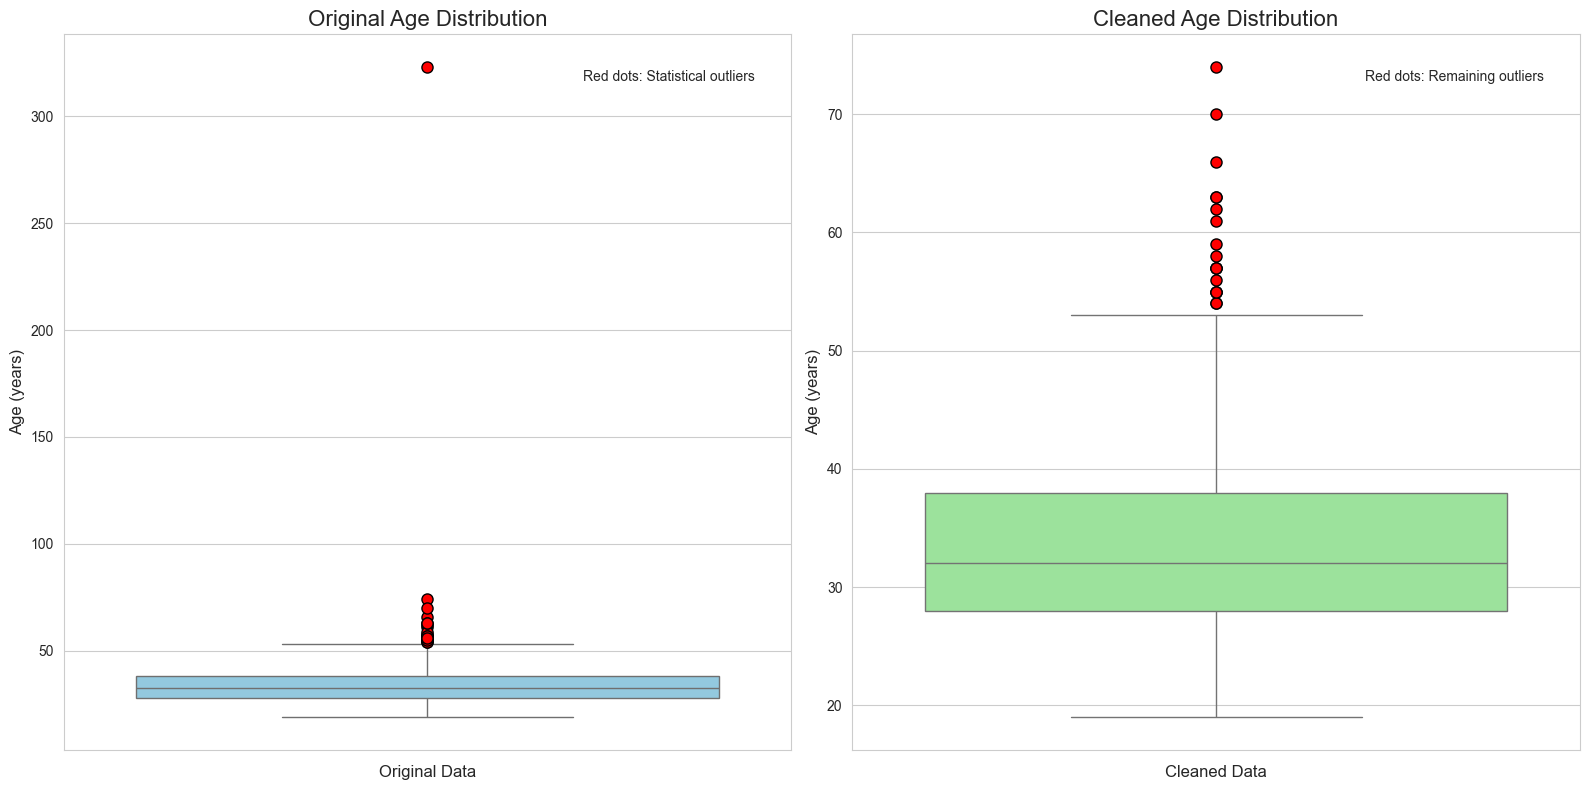


Descriptive Statistics - Original Age Distribution:
count    704.000000
mean      34.365057
std       13.546043
min       19.000000
25%       28.000000
50%       32.500000
75%       38.250000
max      323.000000
Name: age, dtype: float64

Descriptive Statistics - Cleaned Age Distribution:
count    704.000000
mean      33.951705
std        8.051431
min       19.000000
25%       28.000000
50%       32.000000
75%       38.000000
max       74.000000
Name: age, dtype: float64


In [21]:
# Create a copy of the DataFrame to avoid modifying the original
df_cleaned = df.copy()

# List of outlier values identified in the age column. All the other outliers we have see in the visualization in the data exploration part must have been in rows, we already excluded (e.g. outside of USA).
outliers = [323]

# Calculate the median of non-outlier ages using boolean indexing
median_age = df_cleaned[~df_cleaned['age'].isin(outliers)]['age'].median()

# Replace outliers and missing values with the calculated median
df_cleaned['age'] = df_cleaned['age'].replace(outliers, median_age)
df_cleaned['age'] = df_cleaned['age'].fillna(median_age)

# Create a figure with two subplots for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

# Visualize original data distribution
sns.boxplot(data=df, y='age', color='skyblue', ax=ax1, 
            flierprops={'marker': 'o', 'markerfacecolor': 'red', 
                       'markersize': 8, 'markeredgecolor': 'black'})
ax1.set_title('Original Age Distribution', fontsize=16)
ax1.set_ylabel('Age (years)', fontsize=12)
ax1.set_xlabel('Original Data', fontsize=12)

# Add annotation for original data
ax1.text(0.95, 0.95, 'Red dots: Statistical outliers', 
         transform=ax1.transAxes, 
         verticalalignment='top', 
         horizontalalignment='right',
         bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

# Visualize cleaned data distribution
sns.boxplot(data=df_cleaned, y='age', color='lightgreen', ax=ax2, 
            flierprops={'marker': 'o', 'markerfacecolor': 'red', 
                       'markersize': 8, 'markeredgecolor': 'black'})
ax2.set_title('Cleaned Age Distribution', fontsize=16)
ax2.set_ylabel('Age (years)', fontsize=12)
ax2.set_xlabel('Cleaned Data', fontsize=12)

# Add annotation for cleaned data
ax2.text(0.95, 0.95, 'Red dots: Remaining outliers', 
         transform=ax2.transAxes, 
         verticalalignment='top', 
         horizontalalignment='right',
         bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

# Optimize layout
plt.tight_layout()

# Display the visualization
plt.show()

# Display descriptive statistics for comparison
print("\nDescriptive Statistics - Original Age Distribution:")
print(df['age'].describe())
print("\nDescriptive Statistics - Cleaned Age Distribution:")
print(df_cleaned['age'].describe())

# Update the original DataFrame for subsequent analysis
df = df_cleaned

> #### Next we will look at the mental health conditions. We will create a new column that indicates if the person has any condition and drop the columns that indicate if the person has a specific condition.

In [22]:
# In this part the different mental health conditions are grouped and categorized
# List of all unique conditions
conditions = [
    'Anxiety Disorder',
    'Mood Disorder',
    'Attention Deficit Hyperactivity Disorder',
    'Post-traumatic Stress Disorder',
    'Stress Response Syndromes',
    'Personality Disorder',
    'Obsessive-Compulsive Disorder',
    'Eating Disorder',
    'Substance Use Disorder',
    'Addictive Disorder',
    'Psychotic Disorder',
    'Dissociative Disorder',
    'Autism',
    'Asperger Syndrome',
    'Gender Identity Disorder',
    'Intimate Disorder',
    'Traumatic Brain Injury',
    'Seasonal Affective Disorder',
    'Burn out',
    'Depersonalization Disorder',
    'Tinnitus',
    'Suicidal Ideation'
]

# Function to check if a condition is present
# For PDD-NOS we also use Autism
def has_condition(row, condition):
    if pd.isna(row):
        return 0
    if condition == 'Autism':
        return 1 if any(c in row for c in ['Autism', 'PDD-NOS']) else 0
    return 1 if condition in row else 0

# Function to check if any condition is present
def has_any_condition(row):
    if pd.isna(row):
        return 0
    for condition in conditions:
        if condition == 'Autism' and any(c in row for c in ['Autism', 'PDD-NOS']):
            return 1
        elif condition in row:
            return 1
    return 0

# Create binary columns for each condition, that has been professionally diagnosed
for condition in conditions:
    df[f'Has_{condition.replace(" ", "_")}'] = df['diagnosed_conditions'].apply(lambda x: has_condition(x, condition))

# Create a single binary column indicating if the person has any condition
df['has_condition'] = df['diagnosed_conditions'].apply(has_any_condition)

# Get list of columns to potentially drop
columns_to_check = [col for col in df.columns if col.startswith('Has_')]

# Find columns with all zeros
columns_to_drop = [col for col in columns_to_check if df[col].max() == 0]

# Drop two columns that are all zeros, but were not catched for some reason
df = df.drop(columns=['Has_Intimate_Disorder', 'Has_Burn_out'])

# For experimental purposes, let's also drop the columns that indicate if the person has a specific condition'
# Drop the individual condition columns if they exist
columns_to_drop = [col for col in df.columns if col.startswith('Has_')]
df = df.drop(columns=columns_to_drop, errors='ignore')

> #### Drop columns and rows that we wont need in our analysis 

In [24]:
# Drop columns that are not relevant for our analysis
df=df.drop(columns=['country', 'state', 'previous_emp', 'previous_emp_mh_benefits', 'aware_prev_mh_options','prev_employers_discussed_mh', 'prev_mh_resources', 'prev_anonymity_protected', 'prev_neg_consequences_discuss', 'prev_neg_consequences_physical', 'prev_comfortable_discuss_coworkers', 'prev_comfortable_discuss_supervisors', 'prev_emp_mh_seriously', 'prev_observed_neg_consequences', 'willing_share_friends_family', 'reveal_clients', 'neg_impact_reveal_clients', 'reveal_coworkers', 'neg_impact_reveal_coworkers', 'neg_consequences_physical_discuss', 'work_interference_treated', 'work_interference_untreated' ])

# Keep only the binary mental health column has_condition
df=df.drop(columns=['believed_conditions','professionally_diagnosed','professional_diagnoses','diagnosed_conditions','past_mh_disorder', 'current_mh_disorder'])

# Drop free text columns
df=df.drop(columns=['mention_discuss_physical_interview_reason','mention_discuss_mh_interview_reason'])

# Drop the columns that only have values for self-employed employees and therefore add no value
df=df.drop(columns=['mh_coverage','know_local_online_resources','mh_affects_productivity', 'productivity_affected_percent'])

# Drop work_state because there is no value for other countries than USA and we can not fill in missing values
df=df.drop(columns=['work_state'])

> #### Next we will look at the missing values in our dataset and drop columns that have too many missing values

In [26]:
# Calculate percentage of missing values
missing_percentages = df.isnull().mean() * 100

# Sort the percentages in descending order and filter out columns with no missing values
missing_percentages_sorted = missing_percentages[missing_percentages > 0].sort_values(ascending=False)

print("\nPercentage of missing values (sorted in descending order):")
for col, pct in missing_percentages_sorted.items():
    print(f"{col}: {pct:.2f}%")


Percentage of missing values (sorted in descending order):
tech_role: 76.28%
others_experience_affect_you: 55.68%
know_mh_options: 3.84%
experienced_unsupportive_response: 3.69%


In [27]:
# drop columns with more than 50% missing values
df = df.drop(columns=['tech_role','others_experience_affect_you'])

> #### Now convert all categorical columns to binary numerical columns using one-hot encoding

In [28]:
# We will now impute missing values for the experienced_unsupportive_response column and transform it into a binary column
# Define experienced_unsupportive_response categories
experienced_unsupportive_response_categories = [
    "No",
    "Maybe/Not sure",
    "Yes"
]

# Create SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')

# Impute missing values
df['experienced_unsupportive_response'] = imputer.fit_transform(df[['experienced_unsupportive_response']]).ravel()

# Combine "Yes" categories
df['experienced_unsupportive_response'] = df['experienced_unsupportive_response'].replace({
    'Yes, I observed': 'Yes',
    'Yes, I experienced': 'Yes'
})

# Function to check experienced_unsupportive_response category
def experienced_unsupportive_response_category(value, category):
    return 1 if value == category else 0

# Create binary columns for each experienced_unsupportive_response category
for category in experienced_unsupportive_response_categories:
    column_name = f"experienced_unsupportive_response_{category.replace('/', '_')}"
    df[column_name] = df['experienced_unsupportive_response'].apply(lambda x: experienced_unsupportive_response_category(x, category))

# Drop the original experienced_unsupportive_response column
df = df.drop(columns=['experienced_unsupportive_response'])


# Drop one catgeory column to avoid multicollinearity
df = df.drop(columns=['experienced_unsupportive_response_Maybe_Not sure'])

In [29]:
# We now do the same for the know_mh_options column
# Define know_mh_options categories
know_mh_options_categories = [
    "Yes",
    "I am not sure",
    "No"
]

# Create SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')

# Impute missing values
df['know_mh_options'] = imputer.fit_transform(df[['know_mh_options']]).ravel()

# Function to check know_mh_options category
def know_mh_options_category(value, category):
    return 1 if value == category else 0

# Create binary columns for each know_mh_options category
for category in know_mh_options_categories:
    column_name = f"know_mh_options_{category.replace(' ', '_')}"
    df[column_name] = df['know_mh_options'].apply(lambda x: know_mh_options_category(x, category))

# Drop the original know_mh_options column
df = df.drop(columns=['know_mh_options'])

# Drop last category column to avoid multicollinearity
df = df.drop(columns=['know_mh_options_I_am_not_sure'])

In [30]:
# Create new column for company_size with ordinal scale
# Define mapping dictionary for company sizes to ordinal values
company_size_mapping = {
    '1-5': 1,
    '6-25': 2,
    '26-100': 3,
    '100-500': 4,
    '500-1000': 5,
    '>1000': 6,
    'More than 1000': 6  # Including both possible versions of 1000+
}

# Function to convert company size to ordinal value
def encode_company_size(size):
    if pd.isna(size):
        return 0  # Handle missing values
    return company_size_mapping.get(size, 0)  # Return 0 for any unmapped values

# Create new ordinal column
df['company_size_ordinal'] = df['company_size'].apply(encode_company_size)

# Drop original company_size column
df = df.drop(columns=['company_size'])

In [31]:
# Create binary columns for emp_mh_benefits column
# Define emp_mh_benefits categories
emp_mh_benefits_categories = [
    "Yes",
    "I don't know",
    "No",
    "Not eligible for coverage / N/A"
]

# Function to check emp_mh_benefits category
def emp_mh_benefits_category(value, category):
    if pd.isna(value):
        return 0
    return 1 if value == category else 0

# Function to create a valid column name
def create_column_name(category):
    return "emp_mh_benefits_" + category.replace(' ', '_').replace('/', '').replace("'", "")

# Create binary columns for each emp_mh_benefits category
for category in emp_mh_benefits_categories:
    column_name = create_column_name(category)
    df[column_name] = df['emp_mh_benefits'].apply(lambda x: emp_mh_benefits_category(x, category))

# Drop the original emp_mh_benefits column
df = df.drop(columns=['emp_mh_benefits'])

# Drop last category column to avoid multicollinearity
df = df.drop(columns=['emp_mh_benefits_Not_eligible_for_coverage__NA'])

In [33]:
# Do mass one-hot encoding for similar columns
# Ensure that column names contain only safe characters
def safe_column_name(name):
    return re.sub(r'\W+', '_', str(name))

# I want to create multiple binary columns for each categorical column
def create_binary_columns(df, column_name):
    # Get unique values
    unique_values = df[column_name].dropna().unique()
    
    # Create binary columns for ALL categories
    new_columns = []
    for value in unique_values:
        new_column_name = f"{column_name}_{safe_column_name(value)}"
        df[new_column_name] = (df[column_name] == value).astype(int)
        new_columns.append(new_column_name)
    
    # Drop the original column
    df = df.drop(columns=[column_name])
    
    return df

# List of columns to convert
columns_to_convert = [
    'emp_discussed_mh', 'anonymity_protected', 'mh_resources', 'leave_difficulty',
    'neg_consequences_mental_discuss',
    'comfortable_discuss_coworkers', 'comfortable_discuss_supervisors',
    'emp_mh_seriously', 'observed_neg_consequences', 'mention_discuss_physical_interview',
    'mention_discuss_mh_interview', 'mh_hurt_career', 'coworkers_view_negatively',
    'family_history', 'gender', 'remote_work'
]

# Apply the conversion to each column
for column in columns_to_convert:
    df = create_binary_columns(df, column)

> #### Simplifiy position columns to IT and Management into binary columns

In [35]:
def categorize_position(position):
    roles = position.split('|')
    
    it_roles = ['Back-end Developer', 'Front-end Developer', 'DevOps/SysAdmin', 'Dev Evangelist/Advocate']
    management_roles = ['Executive Leadership', 'Supervisor/Team Lead']
    
    is_it_role = 1 if any(role in it_roles for role in roles) else 0
    is_management = 1 if any(role in management_roles for role in roles) else 0
    
    return is_it_role, is_management

# Categorize positions into IT and Management roles
df['Is_IT_Role'], df['Is_Management'] = zip(*df['position'].apply(categorize_position))

# Drop the original 'position' column
df = df.drop(columns=['position'])

> #### Convert expoerience_unsupportive_response column

In [36]:
# Convert tech_company column to integer type
df['tech_company'] = df['tech_company'].astype(int)

> #### Convert remote_work column to binary columns

In [37]:
# Create remote_work_yes by combining 'Sometimes' and 'Always'
df['remote_work_yes'] = df['remote_work_Sometimes'] | df['remote_work_Always']

# We can keep remote_work_Never as remote_work_no if needed
df['remote_work_no'] = df['remote_work_Never']

# Drop the original columns
df = df.drop(columns=['remote_work_Sometimes', 'remote_work_Always', 'remote_work_Never'])

> #### To further reduce the number of dimensions i create weighted scores out of similar columns.

In [40]:
# Create composite scores (keeping original function)
def create_mental_health_scores(data):
    """
    Creates composite scores using weighted components.
    """
    # Support Score Components
    support_components = {
        'emp_mh_benefits_Yes': (2.0, data['emp_mh_benefits_Yes']),
        'mh_resources_Yes': (1.5, data['mh_resources_Yes']),
        'know_mh_options_Yes': (1.0, data['know_mh_options_Yes']),
        'emp_discussed_mh_Yes': (1.0, data['emp_discussed_mh_Yes']),
        'emp_mh_seriously_Yes': (1.5, data['emp_mh_seriously_Yes']),
        'anonymity_protected_Yes': (1.5, data['anonymity_protected_Yes']),
        'leave_difficulty_Very_easy': (1.0, data['leave_difficulty_Very_easy']),
        'leave_difficulty_Somewhat_easy': (0.5, data['leave_difficulty_Somewhat_easy']),
        'leave_difficulty_Neither_easy_nor_difficult': (0.25, data['leave_difficulty_Neither_easy_nor_difficult'])
    }

    # Stigma Score Components
    stigma_components = {
        'neg_consequences_mental_discuss_Yes': (2.0, data['neg_consequences_mental_discuss_Yes']),
        'mh_hurt_career_Yes_I_think_it_would': (2.0, data['mh_hurt_career_Yes_I_think_it_would']),
        'mh_hurt_career_Maybe': (1.0, data['mh_hurt_career_Maybe']),
        'coworkers_view_negatively_Yes_I_think_they_would': (1.5, data['coworkers_view_negatively_Yes_I_think_they_would']),
        'coworkers_view_negatively_Maybe': (0.75, data['coworkers_view_negatively_Maybe']),
        'experienced_unsupportive_response_Yes': (2.0, data['experienced_unsupportive_response_Yes'])
    }

    # Disclosure Score Components
    disclosure_components = {
        'mention_discuss_mh_interview_Yes': (2.0, data['mention_discuss_mh_interview_Yes']),
        'mention_discuss_physical_interview_Yes': (1.5, data['mention_discuss_physical_interview_Yes']),
        'comfortable_discuss_coworkers_Yes': (1.5, data['comfortable_discuss_coworkers_Yes']),
        'comfortable_discuss_supervisors_Yes': (2.0, data['comfortable_discuss_supervisors_Yes'])
    }

    # Resource Score Components
    resource_components = {
        'emp_mh_benefits_Yes': (2.0, data['emp_mh_benefits_Yes']),
        'know_mh_options_Yes': (1.5, data['know_mh_options_Yes']),
        'mh_resources_Yes': (1.5, data['mh_resources_Yes']),
        'leave_difficulty_Very_easy': (1.0, data['leave_difficulty_Very_easy']),
        'leave_difficulty_Somewhat_easy': (0.5, data['leave_difficulty_Somewhat_easy'])
    }

    def calculate_weighted_score(components):
        weighted_sum = sum(weight * value for weight, value in components.values())
        max_possible = sum(weight for weight, _ in components.values())
        return (weighted_sum / max_possible) * 100

    return pd.DataFrame({
        'support_score': calculate_weighted_score(support_components),
        'stigma_score': calculate_weighted_score(stigma_components),
        'disclosure_score': calculate_weighted_score(disclosure_components),
        'resource_score': calculate_weighted_score(resource_components)
    })

# Create and analyze scores
scores = create_mental_health_scores(df)

# Combine scores with original variables
features_for_clustering = df[[
    'sought_treatment', 'age',
    'has_condition', 'company_size_ordinal', 'family_history_Yes', 'gender_Male', 'remote_work_yes',
    'Is_IT_Role', 'Is_Management'
]].copy()

# Add the composite scores
features_for_clustering = pd.concat([features_for_clustering, scores], axis=1)

# Save df for cluster analysis
fullfeature_df = df.copy()
fullfeature_df['support_score'] = scores['support_score']
fullfeature_df['stigma_score'] = scores['stigma_score']
fullfeature_df['disclosure_score'] = scores['disclosure_score']
fullfeature_df['resource_score'] = scores['resource_score']


In [41]:
features_for_clustering.info()
features_for_clustering.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sought_treatment      704 non-null    int64  
 1   age                   704 non-null    int64  
 2   has_condition         704 non-null    int64  
 3   company_size_ordinal  704 non-null    int64  
 4   family_history_Yes    704 non-null    int64  
 5   gender_Male           704 non-null    int64  
 6   remote_work_yes       704 non-null    int64  
 7   Is_IT_Role            704 non-null    int64  
 8   Is_Management         704 non-null    int64  
 9   support_score         704 non-null    float64
 10  stigma_score          704 non-null    float64
 11  disclosure_score      704 non-null    float64
 12  resource_score        704 non-null    float64
dtypes: float64(4), int64(9)
memory usage: 71.6 KB


,sought_treatment,age,has_condition,company_size_ordinal,family_history_Yes,gender_Male,remote_work_yes,Is_IT_Role,Is_Management,support_score,stigma_score,disclosure_score,resource_score
0,1,29,1,2,1,1,0,1,0,68.292683,0.000000,28.571429,53.846154
1,1,43,1,2,1,0,1,1,1,31.707317,72.972973,0.000000,53.846154
2,0,30,0,3,0,1,1,1,0,19.512195,21.621622,78.571429,7.692308
3,1,37,1,6,1,0,1,1,0,68.292683,40.540541,28.571429,92.307692
4,1,44,1,3,1,0,1,1,0,0.000000,54.054054,21.428571,0.000000


> #### Now we will look at the correlation between the features to see if we have highly correlated columns, which we might want to drop.

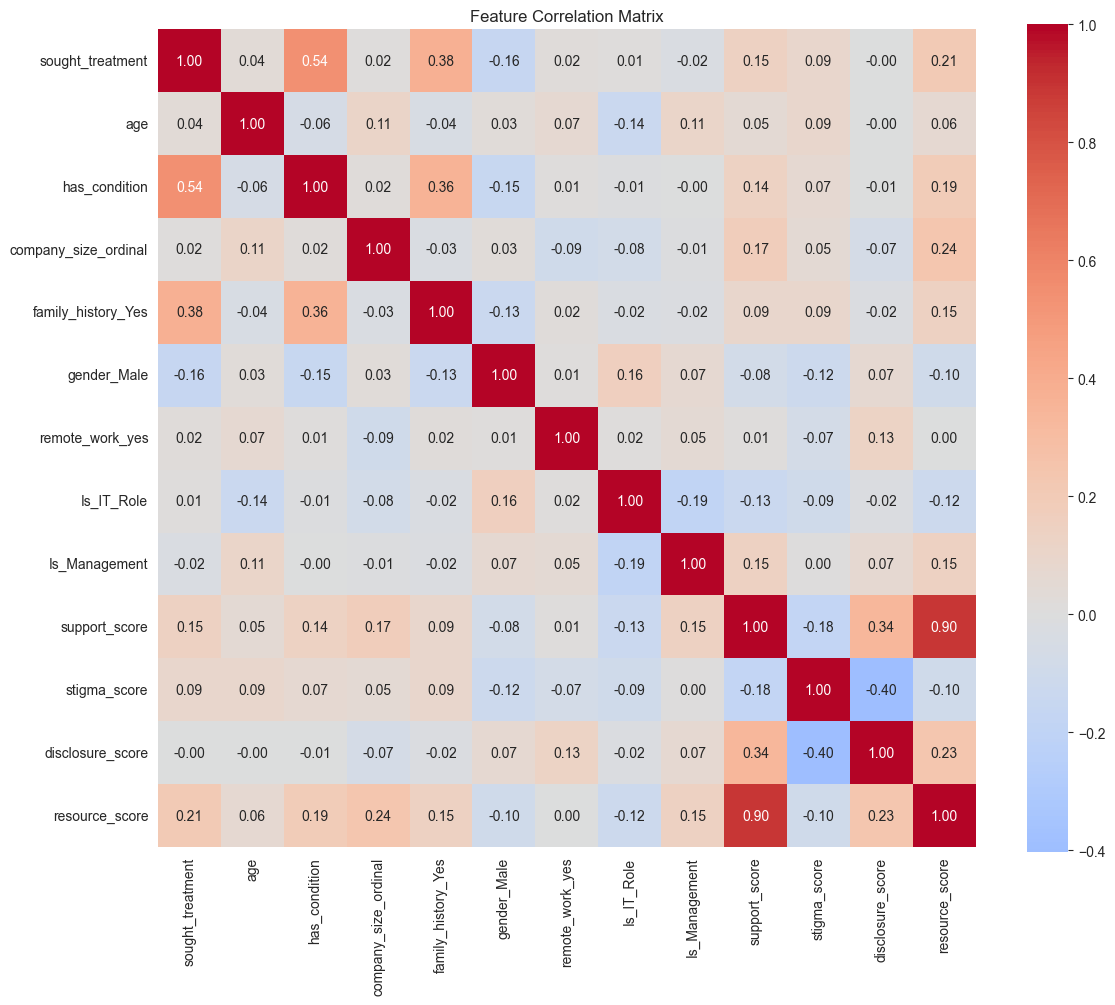


Highly correlated feature pairs (correlation > 0.8):
support_score - resource_score: 0.896
resource_score - support_score: 0.896


In [42]:
# Create correlation matrix
correlation_matrix = features_for_clustering.corr()

# Create heatmap visualization using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            fmt='.2f',  # Show 2 decimal places
            square=True)  # Make cells square
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Find highly correlated feature pairs (above 0.8 for example)
threshold = 0.8
high_corr = np.where(np.abs(correlation_matrix) > threshold)
high_corr = [(correlation_matrix.index[x], correlation_matrix.columns[y], correlation_matrix.iloc[x,y]) 
             for x, y in zip(*high_corr) if x != y]  # Exclude self-correlations

print("\nHighly correlated feature pairs (correlation > 0.8):")
for feat1, feat2, corr in high_corr:
    print(f"{feat1} - {feat2}: {corr:.3f}")

Dropping one of the highly correlated columns, either "support_score" or "resource_score," would reduce redundancy in the dataset, potentially decreasing bias in distance-based clustering algorithms and simplifying the interpretation of resulting clusters. On the other hand, removing one column would sacrifice the nuanced insights each score provides individually—"support_score" measures the perceived psychological support environment, while "resource_score" specifically captures awareness of and access to tangible mental health resources. Ultimately, retaining both columns is justified, despite their statistical correlation, because each contributes distinct actionable information, thereby allowing the HR department to design more precise, targeted interventions for mental health improvement.

> #### As a next step i start PCA analysis to further reduce dimensionality

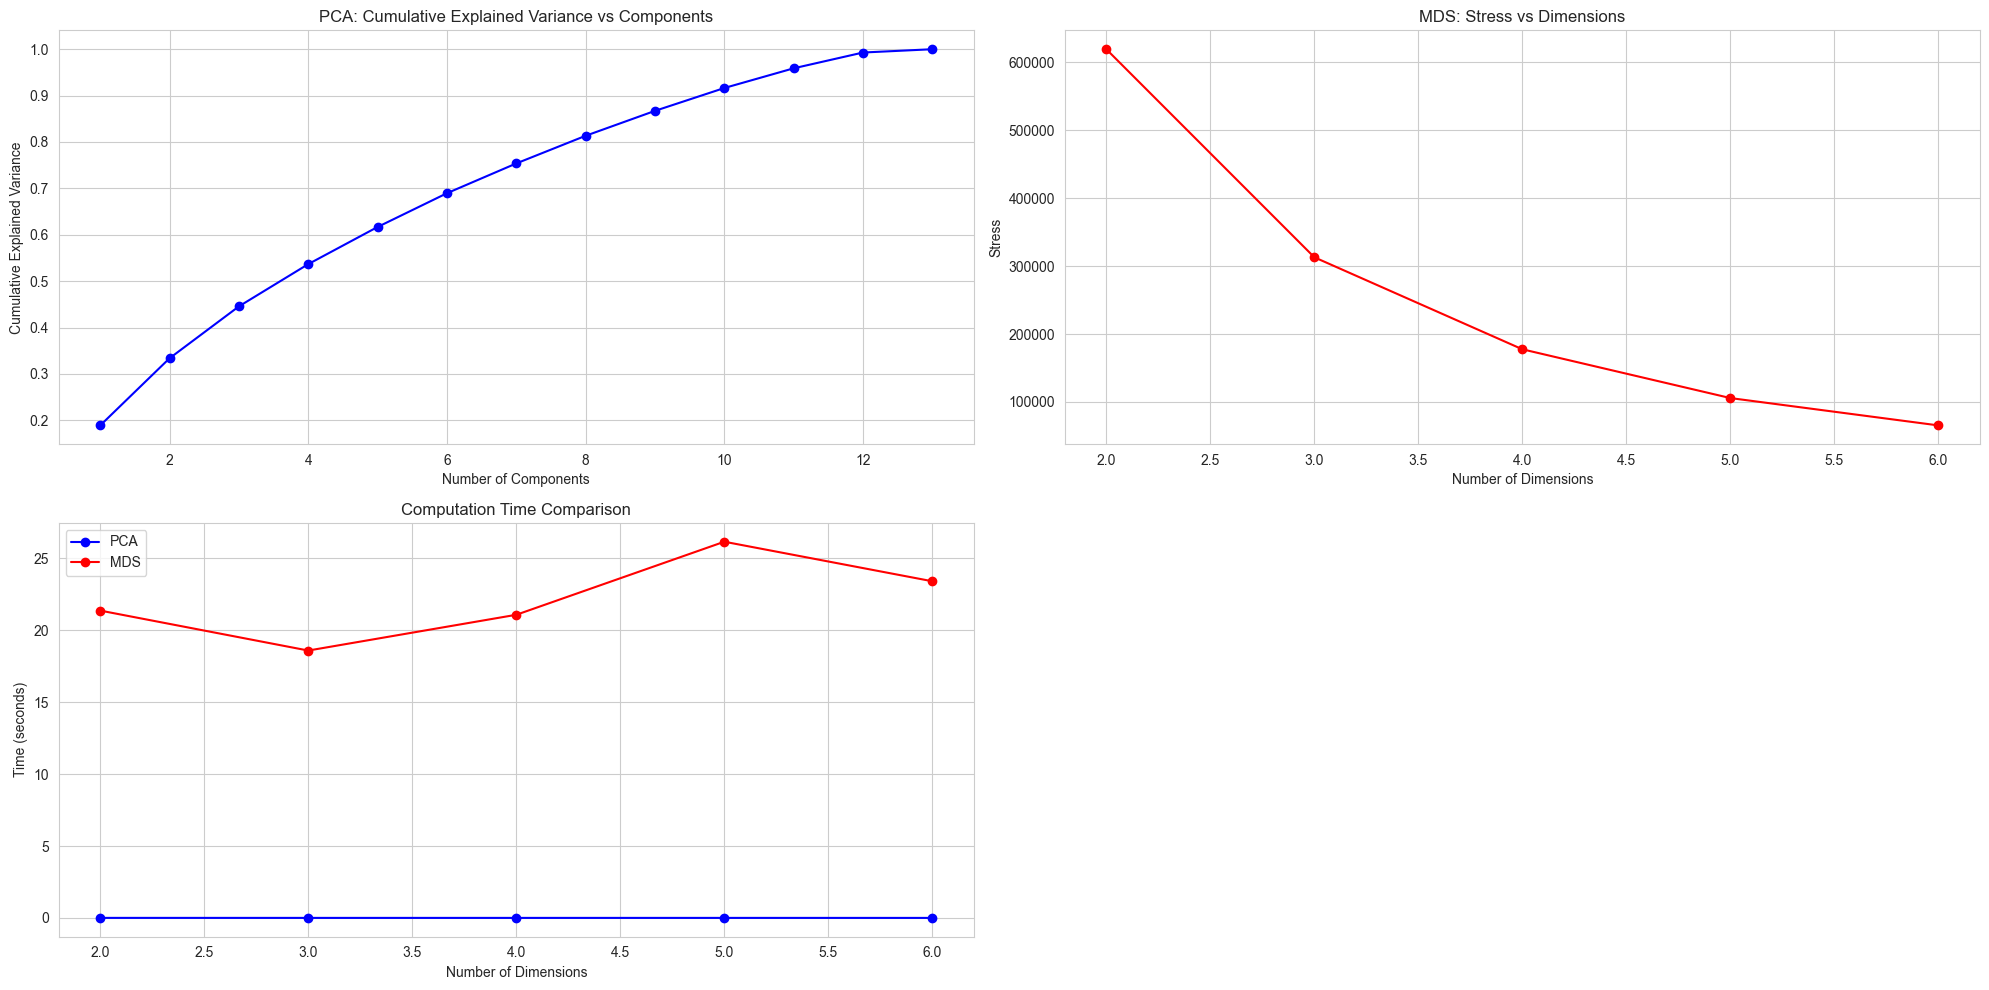


PCA Results:
Cumulative explained variance by dimensions:
1 dimensions: 0.189
2 dimensions: 0.334
3 dimensions: 0.446
4 dimensions: 0.537
5 dimensions: 0.617
6 dimensions: 0.690

MDS Results:
Stress values by dimensions:
2 dimensions: 619423.71
3 dimensions: 313015.11
4 dimensions: 177519.71
5 dimensions: 105675.99
6 dimensions: 65406.73

Computation Times (seconds):
Dimensions  PCA    MDS
         2  0.002 21.375
         3  0.001 18.596
         4  0.001 21.085
         5  0.001 26.166
         6  0.000 23.416


In [43]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(features_for_clustering)

# Set dimensions to try
n_dimensions = [2, 3, 4, 5, 6]

# PCA Analysis
pca = PCA()
data_pca = pca.fit_transform(data_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# MDS Analysis for different dimensions
mds_stress = []
mds_time = []
pca_time = []

for n_dim in n_dimensions:
    # PCA timing
    start_time = time.time()
    pca_n = PCA(n_components=n_dim)
    pca_n.fit_transform(data_scaled)
    pca_time.append(time.time() - start_time)
    
    # MDS timing and stress
    start_time = time.time()
    mds = MDS(n_components=n_dim, random_state=42)
    mds.fit_transform(data_scaled)
    mds_time.append(time.time() - start_time)
    mds_stress.append(mds.stress_)

# Plotting
plt.figure(figsize=(20, 10))

# Plot 1: PCA explained variance
plt.subplot(2, 2, 1)
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance vs Components')
plt.grid(True)

# Plot 2: MDS Stress by dimensions
plt.subplot(2, 2, 2)
plt.plot(n_dimensions, mds_stress, 'ro-')
plt.xlabel('Number of Dimensions')
plt.ylabel('Stress')
plt.title('MDS: Stress vs Dimensions')
plt.grid(True)

# Plot 3: Computation Time Comparison
plt.subplot(2, 2, 3)
plt.plot(n_dimensions, pca_time, 'bo-', label='PCA')
plt.plot(n_dimensions, mds_time, 'ro-', label='MDS')
plt.xlabel('Number of Dimensions')
plt.ylabel('Time (seconds)')
plt.title('Computation Time Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print detailed results
print("\nPCA Results:")
print("Cumulative explained variance by dimensions:")
for i, var in enumerate(cumulative_variance[:6], 1):
    print(f"{i} dimensions: {var:.3f}")

print("\nMDS Results:")
print("Stress values by dimensions:")
for dim, stress in zip(n_dimensions, mds_stress):
    print(f"{dim} dimensions: {stress:.2f}")

print("\nComputation Times (seconds):")
print("Dimensions  PCA    MDS")
for dim, p_time, m_time in zip(n_dimensions, pca_time, mds_time):
    print(f"{dim:10d} {p_time:6.3f} {m_time:6.3f}")

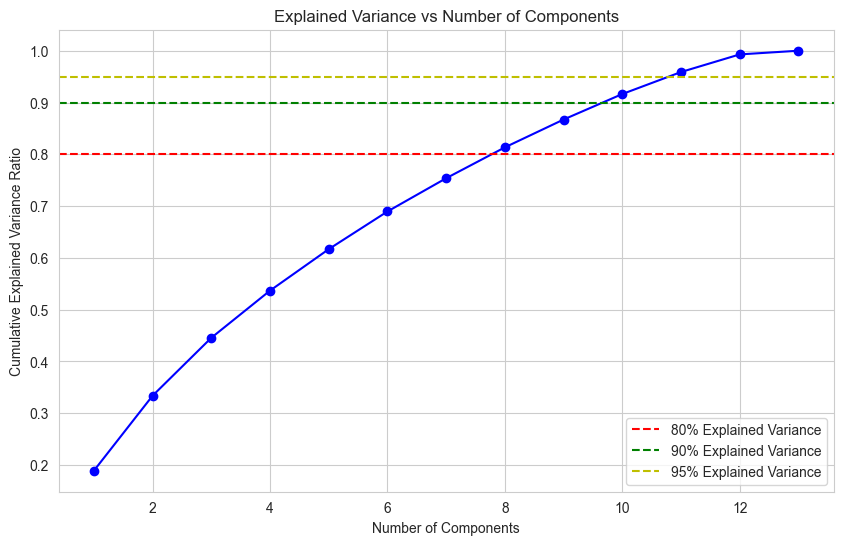


Number of components needed for:
80% variance: 8
90% variance: 10
95% variance: 11


In [44]:
# Prepare data for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_for_clustering)

# Determine optimal number of PCA components
n_components = min(X_scaled.shape[0], X_scaled.shape[1])
pca_test = PCA(n_components=n_components)
pca_test.fit(X_scaled)

# Plot cumulative explained variance ratio
plt.figure(figsize=(10, 6))
cumsum = np.cumsum(pca_test.explained_variance_ratio_)
plt.plot(range(1, n_components + 1), cumsum, 'bo-')

# Add multiple threshold lines
plt.axhline(y=0.80, color='r', linestyle='--', label='80% Explained Variance')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% Explained Variance')
plt.axhline(y=0.95, color='y', linestyle='--', label='95% Explained Variance')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance vs Number of Components')
plt.legend()
plt.grid(True)
plt.show()

# Print the number of components needed for each threshold
n_components_80 = np.argmax(cumsum >= 0.80) + 1
n_components_90 = np.argmax(cumsum >= 0.90) + 1
n_components_95 = np.argmax(cumsum >= 0.95) + 1

print(f"\nNumber of components needed for:")
print(f"80% variance: {n_components_80}")
print(f"90% variance: {n_components_90}")
print(f"95% variance: {n_components_95}")

# Apply PCA with chosen number of components -> i chose 80% explained variance
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Clustering

> #### Determine the optimal number of clusters using silhouette scores

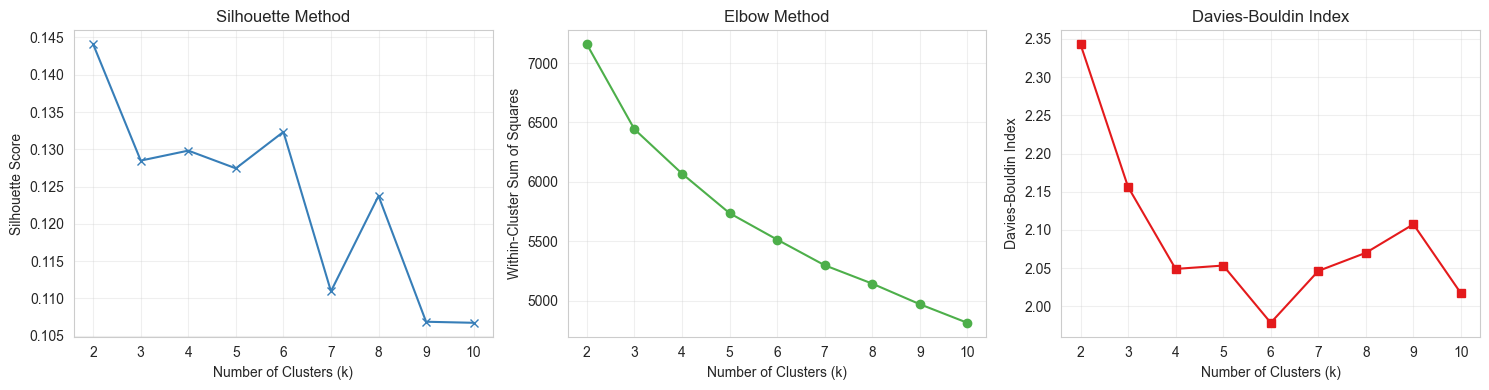

Silhouette Score (higher is better): Optimal k = 2
Elbow Method (look for bend): Check plot for visual determination
Davies-Bouldin Index (lower is better): Optimal k = 6


In [45]:
# Set style parameters
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
wcss_scores = []  # Within-cluster sum of squares for Elbow method
db_scores = []    # Davies-Bouldin index
k_range = range(2, 11)

for k in k_range:
    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_pca)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    # Calculate WCSS for Elbow method
    wcss = kmeans.inertia_
    wcss_scores.append(wcss)
    
    # Calculate Davies-Bouldin index
    db_index = davies_bouldin_score(X_pca, cluster_labels)
    db_scores.append(db_index)

# Create a figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Silhouette Score
ax1.plot(k_range, silhouette_scores, color='#377EB8', marker='x', linestyle='-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Method')
ax1.grid(True, alpha=0.3)

# Plot 2: Elbow Method
ax2.plot(k_range, wcss_scores, color='#4DAF4A', marker='o', linestyle='-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Within-Cluster Sum of Squares')
ax2.set_title('Elbow Method')
ax2.grid(True, alpha=0.3)

# Plot 3: Davies-Bouldin Index
ax3.plot(k_range, db_scores, color='#E41A1C', marker='s', linestyle='-')
ax3.set_xlabel('Number of Clusters (k)')
ax3.set_ylabel('Davies-Bouldin Index')
ax3.set_title('Davies-Bouldin Index')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print the optimal values for each method
print(f"Silhouette Score (higher is better): Optimal k = {k_range[np.argmax(silhouette_scores)]}")
print(f"Elbow Method (look for bend): Check plot for visual determination")
print(f"Davies-Bouldin Index (lower is better): Optimal k = {k_range[np.argmin(db_scores)]}")

The choice of k=2 was guided primarily by the Silhouette method, which clearly indicated the highest silhouette score at two clusters, suggesting the best-defined separation between groups. Additionally, the Elbow method showed a noticeable bend at k=2, indicating that further increases in cluster count would yield diminishing returns in terms of within-cluster variance reduction. While the Davies-Bouldin Index suggested an optimal k=6, the improvement was marginal, making k=2 the most coherent and interpretable choice.

> #### Now we will apply different clustering algorithms to the PCA-reduced data and choose which algorithms fits best.

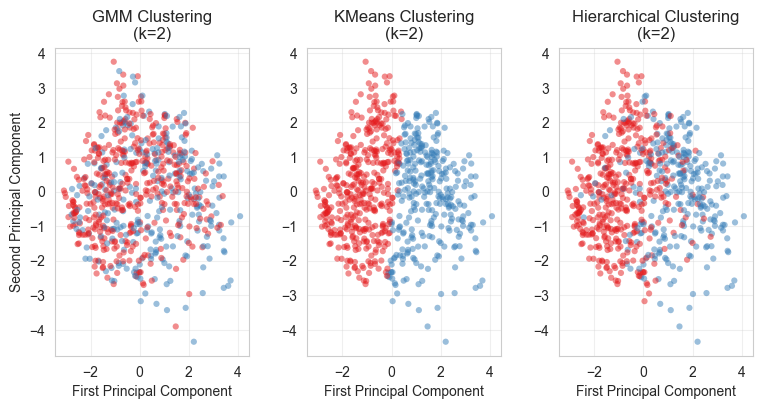


Comparison metrics for 2 clusters:

GMM:
Silhouette score: 0.117
Calinski-Harabasz score: 70.901
Davies-Bouldin score: 3.047
Cluster sizes: [437 267]

KMeans:
Silhouette score: 0.143
Calinski-Harabasz score: 120.723
Davies-Bouldin score: 2.350
Cluster sizes: [396 308]

Hierarchical:
Silhouette score: 0.110
Calinski-Harabasz score: 79.476
Davies-Bouldin score: 2.851
Cluster sizes: [430 274]


In [46]:
# Set style parameters
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# Create figure with A4 width dimensions
fig = plt.figure(figsize=(9, 4))
gs = fig.add_gridspec(1, 3, wspace=0.3)

n_fixed_clusters = 2
final_clusters = {}

# GMM
gmm = GaussianMixture(n_components=n_fixed_clusters, random_state=42, n_init=10)
final_clusters['GMM'] = gmm.fit_predict(X_pca)

# K-means
kmeans = KMeans(n_clusters=n_fixed_clusters, random_state=42, n_init=10)
final_clusters['KMeans'] = kmeans.fit_predict(X_pca)

# Hierarchical
hierarchical = AgglomerativeClustering(n_clusters=n_fixed_clusters)
final_clusters['Hierarchical'] = hierarchical.fit_predict(X_pca)

# Define high contrast colors
colors = ['#E41A1C', '#377EB8']  # Red and Blue

# Plot clustering results with improved visuals
for i, (method, labels) in enumerate(final_clusters.items()):
   ax = fig.add_subplot(gs[0, i])
   scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], 
                       c=[colors[l] for l in labels],
                       alpha=0.5,
                       s=20,
                       linewidth=0)
   ax.set_title(f'{method} Clustering\n(k={n_fixed_clusters})')
   ax.set_xlabel('First Principal Component')
   ax.set_ylabel('Second Principal Component' if i == 0 else '')
   ax.grid(True, alpha=0.3)

plt.show()

# Print comparison metrics
print("\nComparison metrics for 2 clusters:")  # Updated to reflect k=2
for method, labels in final_clusters.items():
   print(f"\n{method}:")
   try:
       silhouette_avg = silhouette_score(X_pca, labels)
       calinski = calinski_harabasz_score(X_pca, labels)
       davies = davies_bouldin_score(X_pca, labels)
       
       print(f"Silhouette score: {silhouette_avg:.3f}")
       print(f"Calinski-Harabasz score: {calinski:.3f}")
       print(f"Davies-Bouldin score: {davies:.3f}")
       print(f"Cluster sizes: {np.bincount(labels)}")
   
   except ValueError as e:
       print(f"Error calculating scores: {e}")

It looks like KMeans seems to be the best fit with the most distinguished clusters.

## Results

In [48]:
# Copy data and add cluster labels
df = fullfeature_df.copy()
df['Cluster'] = final_clusters['KMeans']

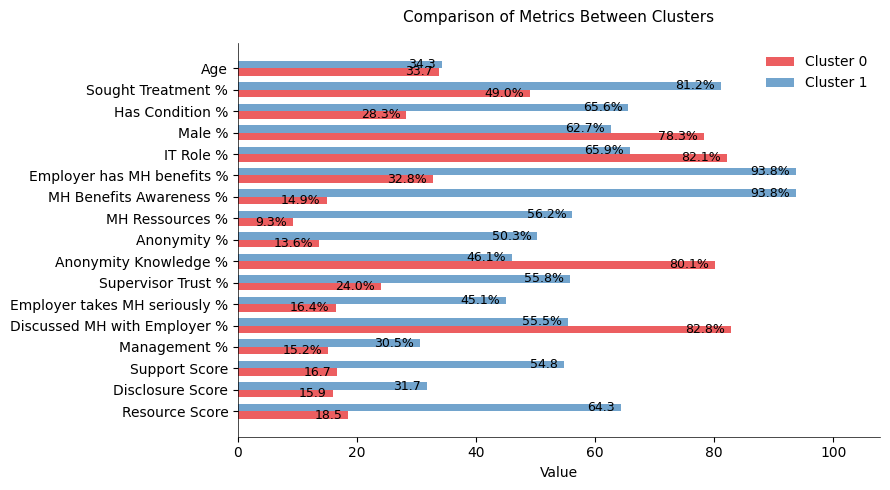

In [49]:
# Set style parameters
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
plt.style.use('default')  # Reset to default style with white background

# Analyze first cluster
cluster_0 = df[df['Cluster'] == 0]
cluster_0_metrics = {
    'Size': len(cluster_0),
    'Age': f"{cluster_0['age'].mean():.1f}",
    'Sought Treatment %': f"{cluster_0['sought_treatment'].mean()*100:.1f}%",
    'Has Condition %': f"{cluster_0['has_condition'].mean()*100:.1f}%",
    'Male %': f"{cluster_0['gender_Male'].mean()*100:.1f}%",
    'IT Role %': f"{cluster_0['Is_IT_Role'].mean()*100:.1f}%",
    'Employer has MH benefits %': f"{cluster_0['emp_mh_benefits_Yes'].mean()*100:.1f}%",
    'MH Benefits Awareness %': f"{cluster_0['know_mh_options_Yes'].mean()*100:.1f}%",
    'MH Ressources %': f"{cluster_0['mh_resources_Yes'].mean()*100:.1f}%",
    'Anonymity %': f"{cluster_0['anonymity_protected_Yes'].mean()*100:.1f}%",
    'Anonymity Knowledge %': f"{cluster_0['anonymity_protected_I_don_t_know'].mean()*100:.1f}%",
    'Supervisor Trust %': f"{cluster_0['comfortable_discuss_supervisors_Yes'].mean()*100:.1f}%",
    'Employer takes MH seriously %': f"{cluster_0['emp_mh_seriously_Yes'].mean()*100:.1f}%",
    'Discussed MH with Employer %': f"{cluster_0['emp_discussed_mh_No'].mean()*100:.1f}%",
    'Management %': f"{cluster_0['Is_Management'].mean()*100:.1f}%",
    'Support Score': f"{cluster_0['support_score'].mean():.1f}",
    'Disclosure Score': f"{cluster_0['disclosure_score'].mean():.1f}",
    'Resource Score': f"{cluster_0['resource_score'].mean():.1f}"
}

# Analyze second cluster
cluster_1 = df[df['Cluster'] == 1]
cluster_1_metrics = {
    'Size': len(cluster_1),
    'Age': f"{cluster_1['age'].mean():.1f}",
    'Sought Treatment %': f"{cluster_1['sought_treatment'].mean()*100:.1f}%",
    'Has Condition %': f"{cluster_1['has_condition'].mean()*100:.1f}%",
    'Male %': f"{cluster_1['gender_Male'].mean()*100:.1f}%",
    'IT Role %': f"{cluster_1['Is_IT_Role'].mean()*100:.1f}%",
    'Employer has MH benefits %': f"{cluster_1['emp_mh_benefits_Yes'].mean()*100:.1f}%",
    'MH Benefits Awareness %': f"{cluster_1['emp_mh_benefits_Yes'].mean()*100:.1f}%",
    'MH Ressources %': f"{cluster_1['mh_resources_Yes'].mean()*100:.1f}%",
    'Anonymity %': f"{cluster_1['anonymity_protected_Yes'].mean()*100:.1f}%",
    'Anonymity Knowledge %': f"{cluster_1['anonymity_protected_I_don_t_know'].mean()*100:.1f}%",
    'Supervisor Trust %': f"{cluster_1['comfortable_discuss_supervisors_Yes'].mean()*100:.1f}%",
    'Employer takes MH seriously %': f"{cluster_1['emp_mh_seriously_Yes'].mean()*100:.1f}%",
    'Discussed MH with Employer %': f"{cluster_1['emp_discussed_mh_No'].mean()*100:.1f}%",
    'Management %': f"{cluster_1['Is_Management'].mean()*100:.1f}%",
    'Support Score': f"{cluster_1['support_score'].mean():.1f}",
    'Disclosure Score': f"{cluster_1['disclosure_score'].mean():.1f}",
    'Resource Score': f"{cluster_1['resource_score'].mean():.1f}"
}

# Remove 'Size' and convert other metrics to numeric values
plot_metrics = {k: float(v.rstrip('%')) if isinstance(v, str) and '%' in v else float(v) 
                for k, v in cluster_0_metrics.items() 
                if k != 'Size'}

# Create lists of metrics and values
metrics = list(plot_metrics.keys())
cluster0_values = [float(cluster_0_metrics[m].rstrip('%')) if isinstance(cluster_0_metrics[m], str) and '%' in cluster_0_metrics[m] 
                   else float(cluster_0_metrics[m]) for m in metrics]
cluster1_values = [float(cluster_1_metrics[m].rstrip('%')) if isinstance(cluster_1_metrics[m], str) and '%' in cluster_1_metrics[m] 
                   else float(cluster_1_metrics[m]) for m in metrics]

# Create figure with dimensions proportional to A4
fig = plt.figure(figsize=(9, 5), facecolor='white')
ax = fig.add_subplot(111)
ax.set_facecolor('white')  # Explicitly set axes background to white

# Define bar positions
y_pos = np.arange(len(metrics))
bar_height = 0.35

# Create bars with specified colors
cluster0_bars = ax.barh(y_pos + bar_height/2, cluster0_values, bar_height, 
                       label='Cluster 0', color='#E41A1C', alpha=0.7, edgecolor='none')
cluster1_bars = ax.barh(y_pos - bar_height/2, cluster1_values, bar_height, 
                       label='Cluster 1', color='#377EB8', alpha=0.7, edgecolor='none')

# Add data labels to each bar
def add_labels(bars, values, metrics_list):
    for bar, value, metric in zip(bars, values, metrics_list):
        width = bar.get_width()
        
        # Format value labels based on the metric type
        if metric == 'Age':
            # For Age, show as years without % symbol
            label_text = f"{value:.1f}"
        elif '%' in metric:
            # For percentage metrics, add % symbol
            label_text = f"{value:.1f}%"
        else:
            # For score metrics, just show the value
            label_text = f"{value:.1f}"
        
        # Position labels at the end of each bar with small padding
        # If the bar is short, place the label outside the bar
        if width < max(cluster0_values + cluster1_values) * 0.05:
            x_pos = width + 1
            ha = 'left'
        else:
            x_pos = width - 1
            ha = 'right'
            
        ax.text(x_pos, 
                bar.get_y() + bar.get_height()/2, 
                label_text, 
                va='center', 
                ha=ha,
                fontsize=9,
                fontweight='normal',
                color='black')  # Ensure text is black for visibility

# Add labels to both sets of bars
add_labels(cluster0_bars, cluster0_values, metrics)
add_labels(cluster1_bars, cluster1_values, metrics)

# Customize plot
ax.set_yticks(y_pos)
ax.set_yticklabels(metrics)
ax.invert_yaxis()  # Reverse order to have first metric at top

# Turn off all grid lines
ax.grid(False)

# Remove top and right spines to match the clean style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Add labels and title with styling
ax.set_xlabel('Value', fontsize=10)
ax.set_title('Comparison of Metrics Between Clusters', fontsize=11, pad=15)

# Add legend with styling to match reference
legend = ax.legend(frameon=False)

# Ensure axes limits include space for labels
max_value = max(cluster0_values + cluster1_values)
ax.set_xlim(0, max_value * 1.15)  # Add 15% margin for labels

# Adjust layout
plt.tight_layout()

# Show plot with clean white background
plt.show()

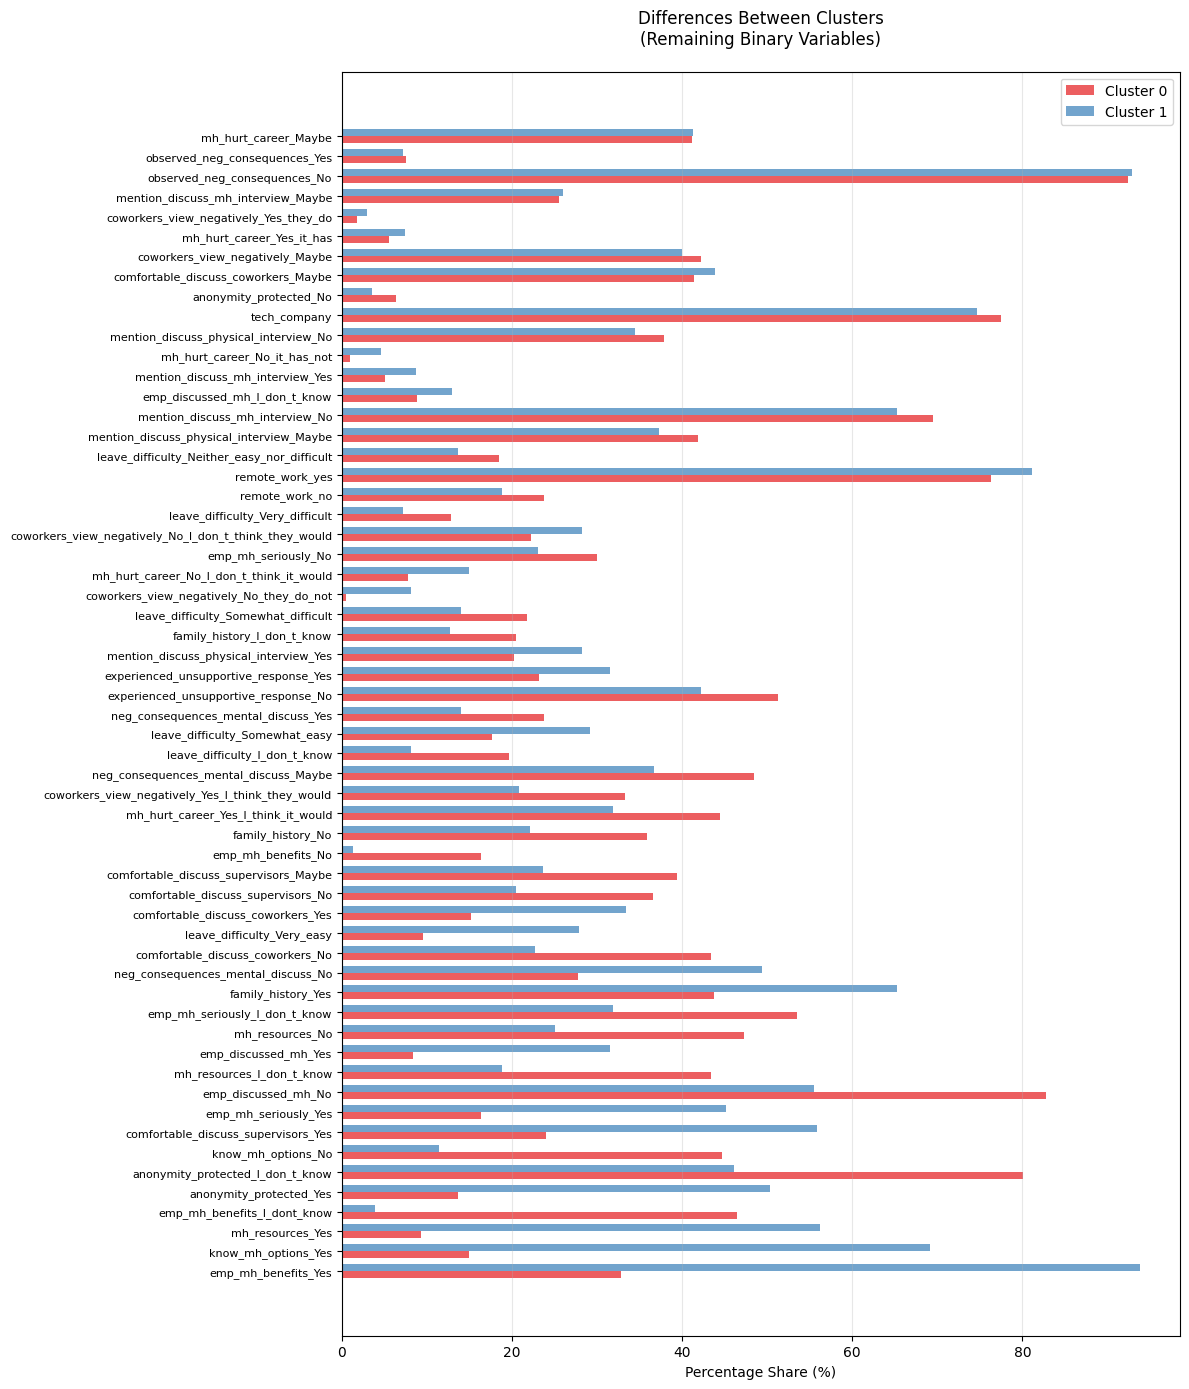


Top binary feature differences between clusters:

emp_mh_benefits_Yes:
  Cluster 0: 32.8%
  Cluster 1: 93.8%
  Absolute Difference: 61.0%

know_mh_options_Yes:
  Cluster 0: 14.9%
  Cluster 1: 69.2%
  Absolute Difference: 54.3%

mh_resources_Yes:
  Cluster 0: 9.3%
  Cluster 1: 56.2%
  Absolute Difference: 46.8%

emp_mh_benefits_I_dont_know:
  Cluster 0: 46.5%
  Cluster 1: 3.9%
  Absolute Difference: 42.6%

anonymity_protected_Yes:
  Cluster 0: 13.6%
  Cluster 1: 50.3%
  Absolute Difference: 36.7%

anonymity_protected_I_don_t_know:
  Cluster 0: 80.1%
  Cluster 1: 46.1%
  Absolute Difference: 33.9%

know_mh_options_No:
  Cluster 0: 44.7%
  Cluster 1: 11.4%
  Absolute Difference: 33.3%

comfortable_discuss_supervisors_Yes:
  Cluster 0: 24.0%
  Cluster 1: 55.8%
  Absolute Difference: 31.9%

emp_mh_seriously_Yes:
  Cluster 0: 16.4%
  Cluster 1: 45.1%
  Absolute Difference: 28.7%

emp_discussed_mh_No:
  Cluster 0: 82.8%
  Cluster 1: 55.5%
  Absolute Difference: 27.3%


In [50]:
# Define columns to exclude (already analyzed)
exclude_columns = ['age', 'Cluster', 'support_score', 'stigma_score', 
                  'disclosure_score', 'resource_score', 'sought_treatment',
                  'has_condition', 'gender_Male', 'gender_Female', 
                  'Is_IT_Role', 'Is_Management', 'company_size_ordinal']

# Calculate means for binary columns
cluster0_means = (cluster_0.mean() * 100)
cluster1_means = (cluster_1.mean() * 100)

# Create differences DataFrame
differences = pd.DataFrame({
    'Cluster0': cluster0_means,
    'Cluster1': cluster1_means,
    'AbsDiff': abs(cluster0_means - cluster1_means)
})

# Drop excluded columns and non-binary columns
differences_cleaned = differences.drop(exclude_columns, errors='ignore')

# Sort by absolute difference
differences_sorted = differences_cleaned.sort_values('AbsDiff', ascending=True)

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 14))

y_pos = np.arange(len(differences_sorted.index))
bar_height = 0.35

# Create bars
ax.barh(y_pos + bar_height/2, differences_sorted['Cluster0'], bar_height, 
        label='Cluster 0', color='#E41A1C', alpha=0.7)
ax.barh(y_pos - bar_height/2, differences_sorted['Cluster1'], bar_height, 
        label='Cluster 1', color='#377EB8', alpha=0.7)

# Customize plot
ax.set_yticks(y_pos)
ax.set_yticklabels(differences_sorted.index, fontsize=8)
ax.invert_yaxis()

# Add grid
ax.grid(True, axis='x', alpha=0.3)

# Add labels and title
ax.set_xlabel('Percentage Share (%)')
ax.set_title('Differences Between Clusters\n(Remaining Binary Variables)', pad=20)

# Add legend
ax.legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Print top differences
print("\nTop binary feature differences between clusters:")
differences_sorted_desc = differences_sorted.sort_values('AbsDiff', ascending=False)
for col in differences_sorted_desc.head(10).index:
    print(f"\n{col}:")
    print(f"  Cluster 0: {differences_sorted_desc.loc[col, 'Cluster0']:.1f}%")
    print(f"  Cluster 1: {differences_sorted_desc.loc[col, 'Cluster1']:.1f}%")
    print(f"  Absolute Difference: {differences_sorted_desc.loc[col, 'AbsDiff']:.1f}%")